<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Copy_of_generative_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two-dimensional data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from typing import List
from numpy.linalg import norm
from IPython.core.formatters import Dict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
from matplotlib.patches import Ellipse
import pickle

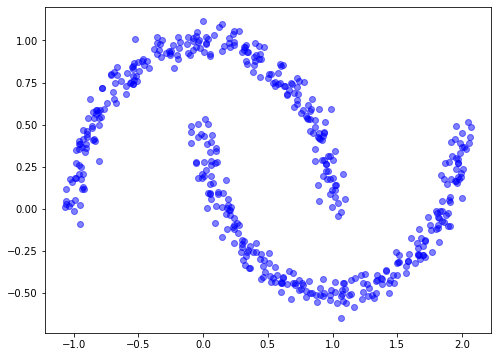

In [ ]:
# Generate the 2D dataset using sklearn
# Create the moon datasets of varying sizes
n_samples_small = 100
n_samples_medium = 500
n_samples_large = 1000

#let's plot the dataset["medium"]
# X, _ = make_moons(n_samples=500, noise=0.05, random_state=0)
Xsmall,_=make_moons(n_samples=n_samples_small, noise=0.05, random_state=0)
Xmid,_=make_moons(n_samples=n_samples_medium, noise=0.05, random_state=0)
Xlarge,_=make_moons(n_samples=n_samples_large, noise=0.05, random_state=0)

datasets=datasets = {
    "Small": Xsmall,
    "Medium": Xmid,
    "Large": Xlarge,
}
# Plot any of the dataset
plt.figure(figsize=(8, 6))
plt.scatter(datasets["Medium"][:,0], datasets["Medium"][:,1], c='blue', label='make_moons dataset', alpha=0.5)

## 1.1 Histogram

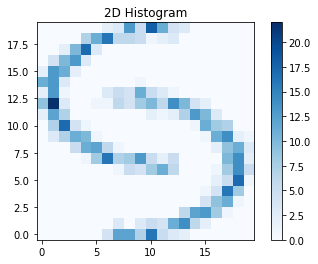

In [ ]:
def train_histogram(X, bins=20):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    x_bins = np.linspace(x_min, x_max, bins + 1)
    y_bins = np.linspace(y_min, y_max, bins + 1)

    histogram = np.zeros((bins, bins), dtype=int)

    for i in range(bins):
        for j in range(bins):
            x_condition = np.logical_and(x_bins[i] <= X[:, 0], X[:, 0] < x_bins[i + 1])
            y_condition = np.logical_and(y_bins[j] <= X[:, 1], X[:, 1] < y_bins[j + 1])
            bin_count = np.sum(np.logical_and(x_condition, y_condition))
            histogram[i, j] = bin_count

    return histogram, x_bins, y_bins

# Train histogram for a specific dataset (e.g., the small one)
X_small = datasets["Large"]
histogram_small, x_bins, y_bins = train_histogram(X_small)

# You can visualize the histogram if needed
plt.imshow(histogram_small, origin='lower', cmap='Blues')
plt.colorbar()
plt.title('2D Histogram')
plt.show()

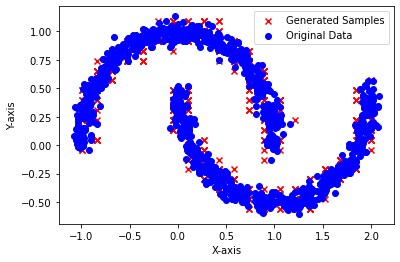

In [ ]:
def generate_samples_from_histogram(histogram, x_bins, y_bins, num_samples):
    # Normalize the histogram to obtain a probability distribution
    histogram_normalized = histogram / np.sum(histogram)

    # Get the shape of the histogram
    num_x_bins, num_y_bins = histogram.shape

    # Generate random indices based on the normalized histogram
    random_indices = np.unravel_index(
        np.random.choice(histogram.size, size=num_samples, p=histogram_normalized.ravel()),
        (num_x_bins, num_y_bins)
    )

    # Map the random indices to bin centers
    x_min, x_max = x_bins[0], x_bins[-1]
    y_min, y_max = y_bins[0], y_bins[-1]
    x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2
    x_samples = x_bin_centers[random_indices[0]]
    y_samples = y_bin_centers[random_indices[1]]

    return np.column_stack((x_samples, y_samples))

# Example of generating data samples from the small histogram
num_samples_to_generate = 1000
generated_samples = generate_samples_from_histogram(histogram_small, x_bins, y_bins, num_samples_to_generate)

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', marker='x', label='Generated Samples')

# You can also overlay the original data points for comparison
plt.scatter(X_small[:, 0], X_small[:, 1], c='blue', marker='o', label='Original Data')

# Set labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

## 1.2 Single Gaussian Distribution model

In [ ]:
### define n- dimensional gaussian distribution
def gaussian_multivar(x:np.array,mean:np.array,cov_mat:np.array):
  '''
  This model will evaluate the probabilty at the given x_vector using the GMM model.
  Args:
  1. x= np array of shape (1 X dimn_of_the_problem)
  2. mean= np array of shape (1 X dimn_of_the_problem)
  3.cov_mat= square np array of shape (dimn_of_the_prob)
  '''
  dimn=np.shape(x)[0]
  inv_cov=np.linalg.inv(cov_mat)
  x_minus_mu=x-mean
  # argument for the exp
  arg_for_expn=0.5*(x_minus_mu @ inv_cov @ np.transpose(x_minus_mu))[0,0]
  det_cov=np.linalg.det(cov_mat)
  # evaluating the prob
  prob=np.exp(-arg_for_expn) * (1./(np.sqrt(det_cov*((2*np.pi)**dimn))))

  return prob

In [ ]:
import numpy as np
from scipy.linalg import cholesky
from scipy.special import erfinv

def sample_multivariate_gaussian(mean, covariance, num_samples=1):
    """
    Sample from an n-dimensional Gaussian distribution.

    Args:
        mean: Mean vector (1D array) of length n. (1,)
        covariance: Covariance matrix (2D array) of shape (n, n).
        num_samples: Number of samples to generate (default is 1).

    Returns:
        samples: Array of shape (num_samples, n) containing generated samples.
    """
    n = len(mean)

    # Generate random vectors 'u' from a uniform distribution
    u = np.random.rand(num_samples, n)

    # Use the inverse error function (probit function) to transform 'u' into standard normal samples
    z_standard_normal = np.sqrt(2) * erfinv(2 * u - 1)

    # Apply the Cholesky decomposition to the covariance matrix
    L = cholesky(covariance, lower=True)

    # Transform standard normal samples into multivariate Gaussian samples
    samples = np.dot(z_standard_normal, L.T) + mean

    return samples

# Example usage:
# mean_vector = np.array([0.0, 0.0])
# covariance_matrix = np.array([[1.0, 0.5], [0.5, 1.0]])
# generated_samples = sample_multivariate_gaussian(mean_vector, covariance_matrix, num_samples=100)


## 1.3 Gaussian mixture model (GMM)

In [ ]:
def gaussian_mixture_model(x_input:np.array, mixing_coeffs:np.array, mean_array:np.array, covs:Dict):
  '''
  Args:
  1. x_input: x vector at which one wants to evaluate the GMM model.
              A numpy array (row vector) of shape (1 X dimn of the problem)
  2. mean:  A numpy arrray of shape (L X dimn of the problem instance)
  3. mixing coeffs: a numpy array of shape (1 X L)
  4. covs: dict of covaraince matrices, L number of entries, one for each of the P_l(x).
  '''
  L=np.shape(mean_array)[0]
  dimn_of_the_prob=np.shape(x_input)[1]
  list_gmm=[mixing_coeffs[0,idx_el] * gaussian_multivar(x=x_input, mean=mean_array[idx_el,:],cov_mat=covs[idx_el])
            for idx_el in range(0,L)
            ]
  prob=sum(list_gmm)## sometimes instead of 1./num_data , literature uses the factor 1./(bandwidth X num_data)
  return prob

### EM algorithm for training the params for the GMM

In [ ]:
def EM_training(mean:np.array,mixing_coeffs:np.array,covs:Dict, dataset_input:np.array,num_iters:int=500,tol:float=0.0001):
  '''
  Args:
  mean= a numpy array
        shape(mean)= (L X dimension_of_the_problem_instance (whether 1D, 2D, 3D and so on))
  mixing_coeffs=
        shape(mixing_coeffs)= (1 X L)
  covs= dict of covariance matrices.
        shape(covs)= L number of entries, one for each of the P_l(x)
  dataset_input: shape would be (num of data set X dimn_of_the_prob)
  '''
  L=np.shape(mean)[0]
  print("L is:");print(L)
  dimn_of_prob=np.shape(dataset_input)[1]
  # define gamma: responsibility
  num_data=np.shape(dataset_input)[0] ### note shape(dataset_input)=(num data X dimn_of_the_problem)
  gamma=np.zeros(shape=(num_data,L))
  prev_log_likelihood = -np.inf  # Initialize the log-likelihood to negative infinity
  ###
  for t in range(0,num_iters):

    ### evaluate the E step
    # update the gamma.
    for idx_over_data in range(0,num_data):
      prod_mixing_coeffs_and_gaussian_l=[mixing_coeffs[0,idx_el]*gaussian_multivar(x=dataset_input[idx_over_data,:].reshape((1,dimn_of_prob)),mean=mean[idx_el,:].reshape((1,dimn_of_prob)),cov_mat=covs[idx_el]) for idx_el in range(0,L)]
      Dr_for_gamma=np.sum(prod_mixing_coeffs_and_gaussian_l)
      gamma[idx_over_data,:]=[prod_mixing_coeffs_and_gaussian_l[k]/Dr_for_gamma for k in range(0,L)]

    #print("gamma obtained:");print(gamma)
    ### M-step: Re-estimating the parameters
    N_l=np.sum(gamma,axis=0)# this is the expression sum_{i=1}^{N(all dataset)} gamma_{il} in the lecture notes
    #print("N_l is:");print(N_l)# NOTE:: shape of N_l = (L,) (note that this array is 1D)

    ### 1. update means: the expresion is like a wtd sum of the vectors
    for idx_el in range(0,L):
      #print("index el is:");print(idx_el)
      temp_vec=np.array(
          [gamma[idx_over_data,idx_el]*dataset_input[idx_over_data,:]
           for idx_over_data in range(0,num_data)]
          )
      mean[idx_el,:]=(1./N_l[idx_el])*np.sum(temp_vec,axis=0)
    #print("mean matrix after update:");print(mean)

    ### 2. update the covariance matrix:
    ##### formula for updating the cov mat is:
    ##### sigma_lth=1/N_l[idx_el] * sum_{i=1}^{N(all_dataset)} * gamma_{il}*some_outer_product
    for idx_el in range(0,L):
      #print("updating cov matrix, index el is:",idx_el)
      temp_outer_prod_list=np.array(
          [gamma[idx_over_data,idx_el]*(dataset_input[idx_over_data,:]-mean[idx_el,:]).reshape((dimn_of_prob,1)) @
           (dataset_input[idx_over_data,:]-mean[idx_el,:]).reshape((1,dimn_of_prob))
          for idx_over_data in range(0,num_data)
         ]
          )
      covs[idx_el]=(1./N_l[idx_el])*sum(temp_outer_prod_list)
    #print("updated covriances");print(covs)

    ### 3. update the mixing coeffs:
    for idx_el in range(0,L):
      mixing_coeffs[0,idx_el]=N_l[idx_el]/num_data

    # Calculate the log-likelihood for the current parameters
    current_log_likelihood = 0
    for idx_over_data in range(num_data):
        log_sum = np.log(sum([mixing_coeffs[0, idx_el] * gaussian_multivar(x=dataset_input[idx_over_data, :].reshape((1, dimn_of_prob)), mean=mean[idx_el, :].reshape((1, dimn_of_prob)), cov_mat=covs[idx_el]) for idx_el in range(L)]))
        current_log_likelihood += log_sum

    # Check for convergence
    if np.abs(current_log_likelihood - prev_log_likelihood) < tol:
        break

    prev_log_likelihood = current_log_likelihood

  return mean,covs,mixing_coeffs

In [ ]:
def fit_the_GMM(X, L):

  # Define your Gaussian function for multivariate data
  def gaussian_multivar(x, mean, cov_mat):
    dimn = np.shape(x)[1]
    inv_cov = np.linalg.inv(cov_mat)
    x_minus_mu = x - mean
    arg_for_expn = 0.5 * np.sum(x_minus_mu @ inv_cov * x_minus_mu, axis=1)
    det_cov = np.linalg.det(cov_mat)
    prob = np.exp(-arg_for_expn) / (np.sqrt(det_cov) * ((2 * np.pi) ** (dimn / 2)))
    return prob

  dimn_of_prob = X.shape[1]

  # Initial guess for GMM parameters
  initial_means = np.random.rand(L, dimn_of_prob)
  initial_covs = [np.eye(dimn_of_prob) for _ in range(L)]
  initial_mixing_coeffs = np.random.rand(1, L)
  initial_mixing_coeffs /= np.sum(initial_mixing_coeffs)  # Normalize

  # Create a dictionary to store covariance matrices
  covariance_matrices = {i: initial_covs[i] for i in range(L)}

  # Train the GMM model using the EM algorithm
  trained_means, trained_covs, trained_mixing_coeffs = EM_training(
      mean=initial_means,
      mixing_coeffs=initial_mixing_coeffs,
      covs=covariance_matrices,
      dataset_input=X,
      num_iters=100,
      tol=0.0001
  )

  print("trained means are:"); print(trained_means)
  print("trained_covs are:");print(trained_covs)
  print("trained_mixing_coeffs are:");print(trained_mixing_coeffs)

  # Plot the original data
  plt.figure(figsize=(8, 6))
  plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)


  # Plot the GMM model
  ###############################
  x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
  xy = np.column_stack([x.ravel(), y.ravel()])
  pdf_values = np.zeros_like(x)
  for idx in range(L):
      #component_pdf = trained_mixing_coeffs[0, idx] * multivariate_normal.pdf(xy, trained_means[idx, :], trained_covs[idx])
      component_pdf = trained_mixing_coeffs[0, idx] * gaussian_multivar(xy, trained_means[idx, :], trained_covs[idx])
      pdf_values += component_pdf.reshape(x.shape)

  # Create a contour plot for the GMM model with a color bar
  contour = plt.contourf(x, y, pdf_values, levels=10, cmap='viridis', alpha=0.5)
  colorbar = plt.colorbar(contour, label='Probability Density')

  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()
  plt.title('GMM Model and make_moons Dataset')
  plt.show()

  #plot_contour_plot_gmm(X,trained_mixing_coeffs,trained_means,trained_covs,L)



  return trained_means, trained_covs, trained_mixing_coeffs

### We employed following strategy to sample from the GMM model:

In a Gaussian Mixture Model (GMM) the multiple Gaussian components  represents a cluster or mode in your data. The "mixing coefficients" indicate the probability of choosing each component when generating data:

*Step 1.* Component Selection: First, one needs to select one of the Gaussian components to generate a data point. We do this by sampling from the mixing coefficients. For example, if we have two components with mixing coefficients [0.4, 0.6], we'd choose the first component with a 40% chance and the second component with a 60% chance.

*Step.2.* Sample from the Selected Component: Once we've selected a component, we sample a data point from that component's Gaussian distribution. This is done by generating random numbers according to the mean and covariance matrix of the selected component's Gaussian distribution.

*Step 3*: Repeat: We repeat these steps to generate as many data points as you need.








In [ ]:
# sample the data_points from the GMM model
def sample_from_gmm(num_samples, mixing_coeffs, mean_array, covs,X, want_scatter_plot=False):
  from scipy.stats import multivariate_normal

  samples = []
  for _ in range(num_samples):
      # Sample a component based on mixing coefficients
      component = np.random.choice(len(mixing_coeffs[0]), p=mixing_coeffs[0])

      # Sample from the selected component
      sample = np.random.multivariate_normal(mean_array[component, :], covs[component])
      samples.append(sample)
  samples=np.array(samples)

  if want_scatter_plot==True:
    plt.figure(2)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
    plt.scatter(samples[:, 0], samples[:, 1], c='red', label='Generated Data', alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Generated Data from GMM Model')
    plt.show()

  return samples

In [ ]:
list(datasets.keys())

['Small', 'Medium', 'Large']

----------------DATASIZE: Small ------------------
index_el: 1
L is:
1
trained means are:
[[0.50006995 0.2464502 ]]
trained_covs are:
{0: array([[ 0.753472  , -0.17935397],
       [-0.17935397,  0.24466648]])}
trained_mixing_coeffs are:
[[1.]]


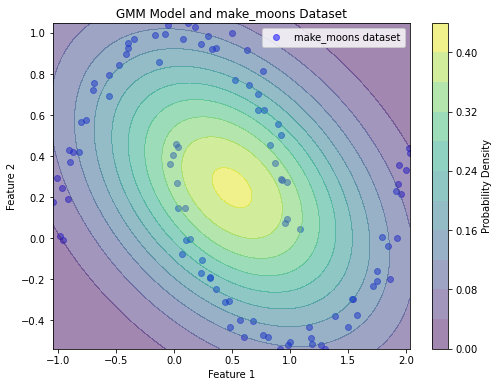

<Figure size 432x288 with 0 Axes>

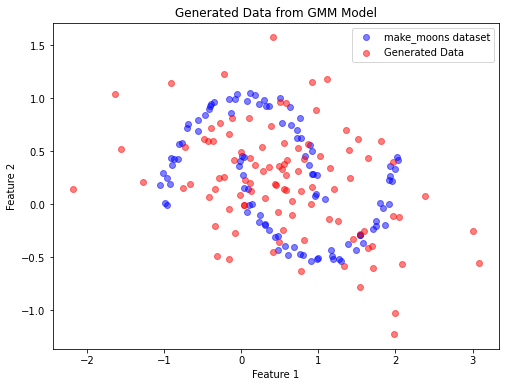

index_el: 2
L is:
2
trained means are:
[[-0.74558341  0.52567036]
 [ 0.80773049  0.17748637]]
trained_covs are:
{0: array([[0.04949048, 0.06245565],
       [0.06245565, 0.09019588]]), 1: array([[ 0.44945309, -0.13195539],
       [-0.13195539,  0.25880665]])}
trained_mixing_coeffs are:
[[0.1980672 0.8019328]]


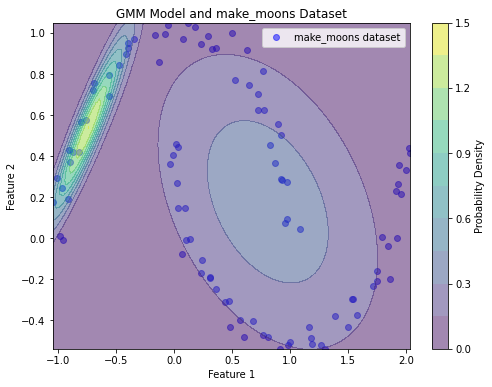

<Figure size 432x288 with 0 Axes>

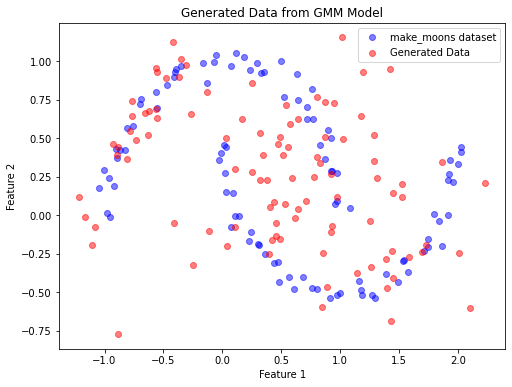

index_el: 3
L is:
3
trained means are:
[[1.8426856  0.05427799]
 [0.26263038 0.8703791 ]
 [0.25505676 0.04727401]]
trained_covs are:
{0: array([[0.02299443, 0.03781829],
       [0.03781829, 0.07308255]]), 1: array([[ 0.17728186, -0.04376167],
       [-0.04376167,  0.02387097]]), 2: array([[ 0.62889964, -0.21284941],
       [-0.21284941,  0.17212155]])}
trained_mixing_coeffs are:
[[0.15317836 0.24067805 0.60614359]]


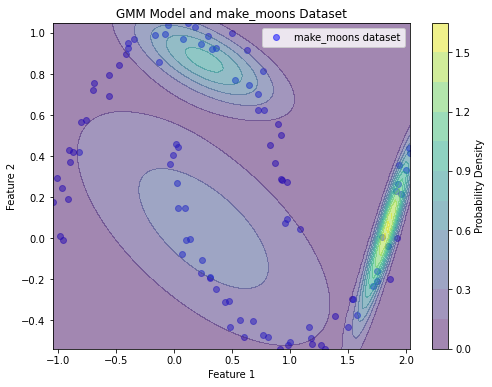

<Figure size 432x288 with 0 Axes>

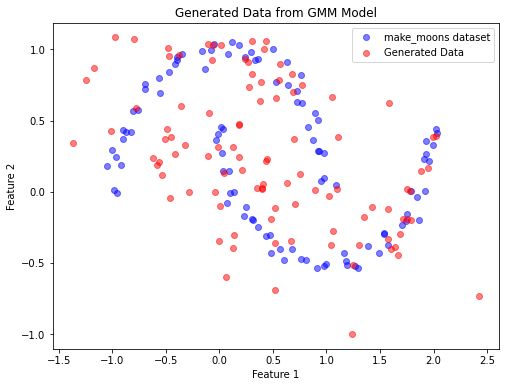

index_el: 4
L is:
4
trained means are:
[[-0.7367726   0.5346918 ]
 [ 1.82009558  0.01735116]
 [ 0.6975532   0.33128879]
 [ 0.23170104 -0.04720182]]
trained_covs are:
{0: array([[0.05123652, 0.06442184],
       [0.06442184, 0.09260104]]), 1: array([[0.02727089, 0.04185551],
       [0.04185551, 0.07728859]]), 2: array([[ 0.18586835, -0.19986214],
       [-0.19986214,  0.35154873]]), 3: array([[ 0.04317331, -0.05613722],
       [-0.05613722,  0.08513509]])}
trained_mixing_coeffs are:
[[0.20940067 0.172114   0.42456175 0.19392358]]


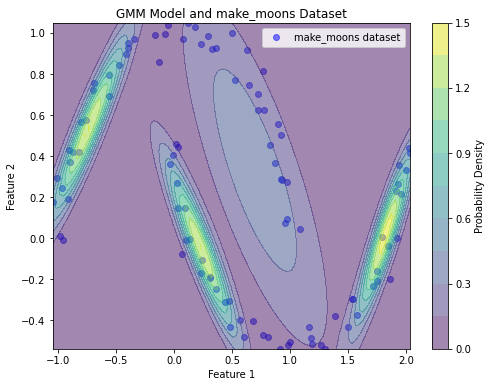

<Figure size 432x288 with 0 Axes>

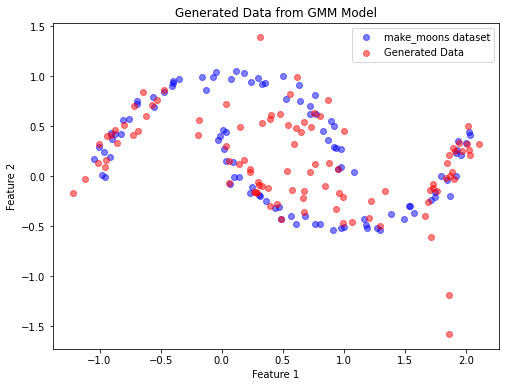

index_el: 5
L is:
5
trained means are:
[[ 0.1999472  -0.00506156]
 [ 0.55191282  0.67883042]
 [ 1.13484307 -0.44854766]
 [-0.73696704  0.53465383]
 [ 1.88715326  0.10526164]]
trained_covs are:
{0: array([[ 0.03584894, -0.05060565],
       [-0.05060565,  0.08419014]]), 1: array([[ 0.15143392, -0.10853929],
       [-0.10853929,  0.10674388]]), 2: array([[0.09846262, 0.01178375],
       [0.01178375, 0.00603905]]), 3: array([[0.05103708, 0.06429864],
       [0.06429864, 0.09254168]]), 4: array([[0.01020388, 0.02159831],
       [0.02159831, 0.05590005]])}
trained_mixing_coeffs are:
[[0.18926699 0.29142813 0.17155877 0.20942594 0.13832017]]


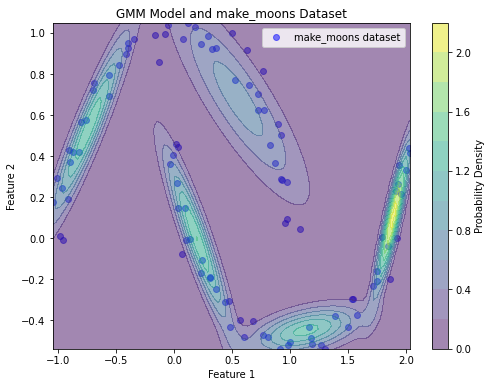

<Figure size 432x288 with 0 Axes>

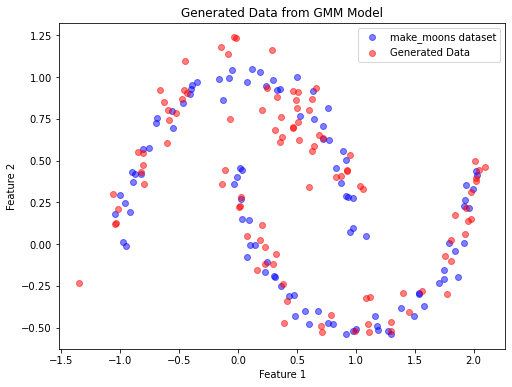

index_el: 6
L is:
6
trained means are:
[[ 0.71084721 -0.38562617]
 [-0.73697049  0.5349469 ]
 [ 1.78290351 -0.02162416]
 [ 0.85875824  0.43972319]
 [ 0.23134134  0.96064214]
 [ 0.02447519  0.30208168]]
trained_covs are:
{0: array([[ 0.12919555, -0.04389447],
       [-0.04389447,  0.01985823]]), 1: array([[0.05078852, 0.06417586],
       [0.06417586, 0.09251548]]), 2: array([[0.03803443, 0.05126056],
       [0.05126056, 0.08377001]]), 3: array([[ 0.01565962, -0.02899184],
       [-0.02899184,  0.06502211]]), 4: array([[ 0.05579529, -0.01177997],
       [-0.01177997,  0.00584606]]), 5: array([[ 0.00590221, -0.01949512],
       [-0.01949512,  0.07576749]])}
trained_mixing_coeffs are:
[[0.21259373 0.20963684 0.1911429  0.15250783 0.1254804  0.10863829]]


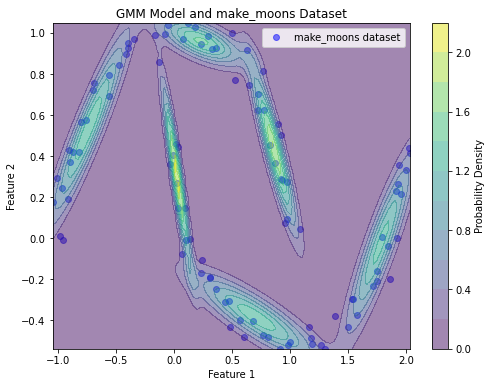

<Figure size 432x288 with 0 Axes>

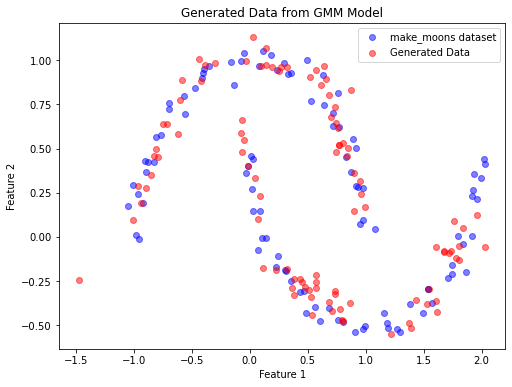

----------------DATASIZE: Medium ------------------
index_el: 1
L is:
1
trained means are:
[[0.49985466 0.24700133]]
trained_covs are:
{0: array([[ 0.74904345, -0.19119175],
       [-0.19119175,  0.2433779 ]])}
trained_mixing_coeffs are:
[[1.]]


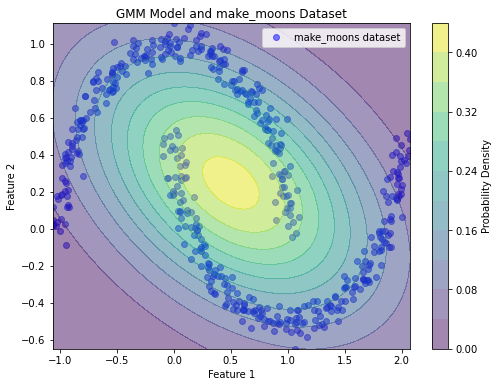

<Figure size 432x288 with 0 Axes>

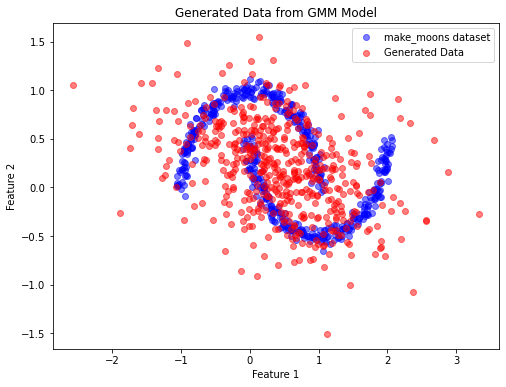

index_el: 2
L is:
2
trained means are:
[[ 0.31767295 -0.16646678]
 [ 0.61293448  0.50364014]]
trained_covs are:
{0: array([[ 0.66051794, -0.22651328],
       [-0.22651328,  0.10509286]]), 1: array([[ 0.77060293, -0.24504331],
       [-0.24504331,  0.1572357 ]])}
trained_mixing_coeffs are:
[[0.38298187 0.61701813]]


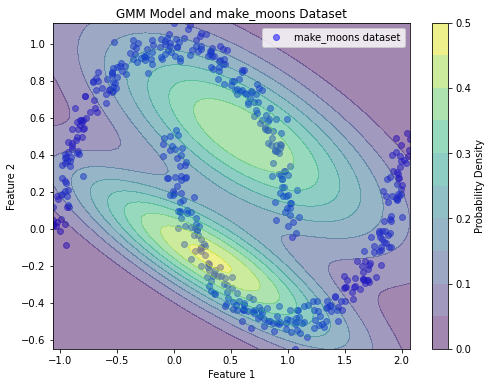

<Figure size 432x288 with 0 Axes>

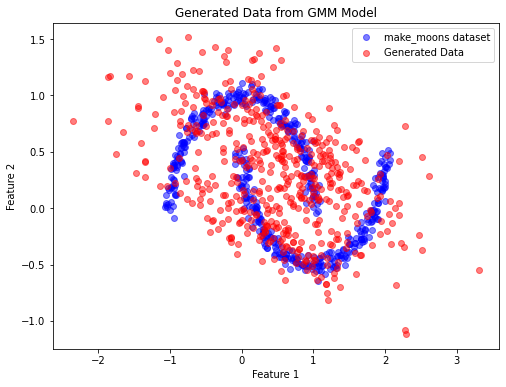

index_el: 3
L is:
3
trained means are:
[[ 0.88318074 -0.43721517]
 [ 0.49194355  0.24551536]
 [ 0.15511246  0.91503993]]
trained_covs are:
{0: array([[ 0.11732655, -0.01485019],
       [-0.01485019,  0.00668849]]), 1: array([[ 1.03853846, -0.14869302],
       [-0.14869302,  0.11378667]]), 2: array([[ 0.12234846, -0.02114077],
       [-0.02114077,  0.01033   ]])}
trained_mixing_coeffs are:
[[0.18128715 0.63163047 0.18708238]]


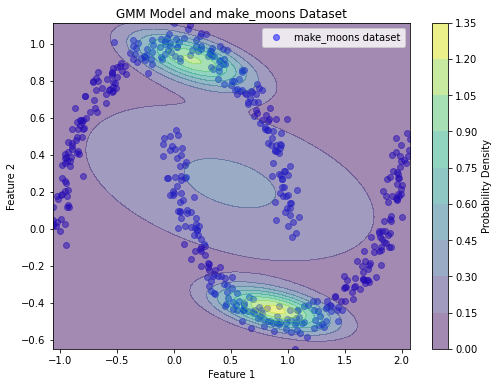

<Figure size 432x288 with 0 Axes>

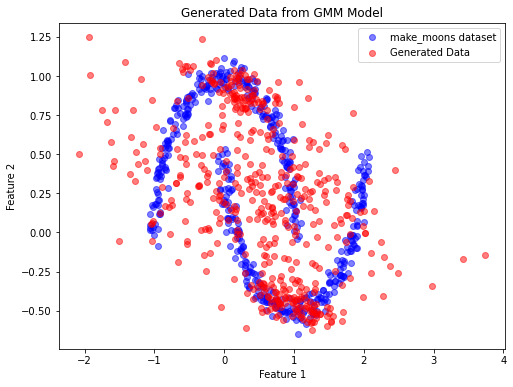

index_el: 4
L is:
4
trained means are:
[[ 0.1850174   0.07018494]
 [ 0.71249528  0.32203565]
 [-0.77693706  0.51732748]
 [ 1.81297369  0.00511756]]
trained_covs are:
{0: array([[ 0.07481688, -0.10930164],
       [-0.10930164,  0.18058396]]), 1: array([[ 0.18062647, -0.20026794],
       [-0.20026794,  0.343937  ]]), 2: array([[0.03889081, 0.05114335],
       [0.05114335, 0.0817261 ]]), 3: array([[0.02835577, 0.04035567],
       [0.04035567, 0.07012229]])}
trained_mixing_coeffs are:
[[0.22818433 0.41104084 0.18892672 0.17184811]]


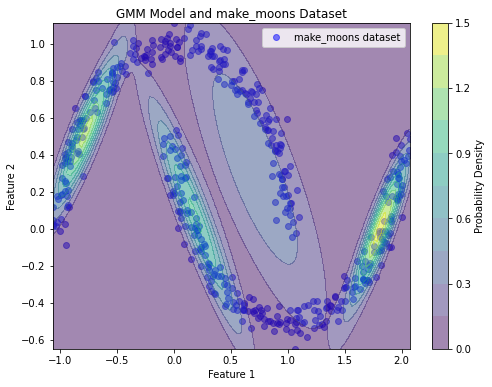

<Figure size 432x288 with 0 Axes>

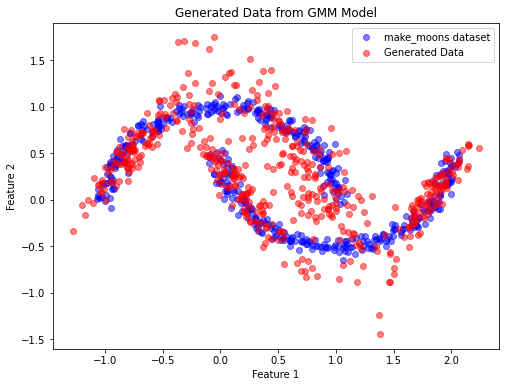

index_el: 5
L is:
5
trained means are:
[[-0.79245893  0.49945845]
 [ 0.28946024  0.53327561]
 [ 0.5940356   0.73926772]
 [ 0.51831545 -0.27655591]
 [ 1.72252228 -0.07994149]]
trained_covs are:
{0: array([[0.03516327, 0.0476193 ],
       [0.0476193 , 0.07891719]]), 1: array([[ 0.2892196 , -0.17155872],
       [-0.17155872,  0.17527007]]), 2: array([[ 0.06087249, -0.04738678],
       [-0.04738678,  0.04146532]]), 3: array([[ 0.11788843, -0.07099237],
       [-0.07099237,  0.05313522]]), 4: array([[0.05888682, 0.06570203],
       [0.06570203, 0.087951  ]])}
trained_mixing_coeffs are:
[[0.17968457 0.22321623 0.15902006 0.22540112 0.21267802]]


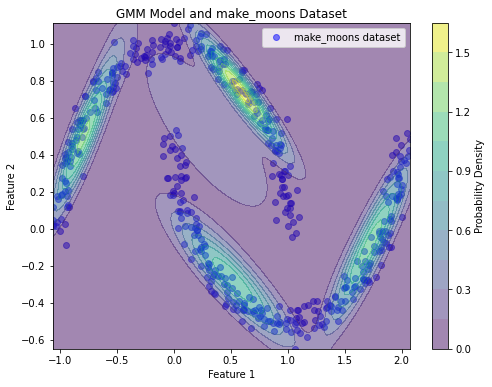

<Figure size 432x288 with 0 Axes>

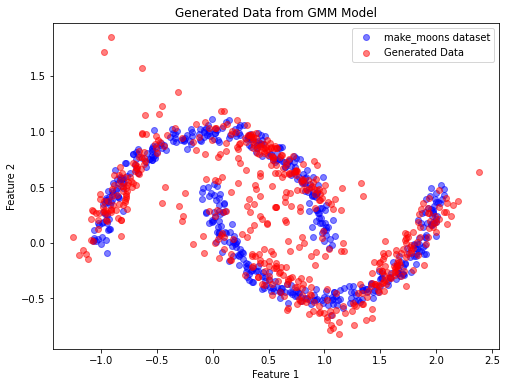

index_el: 6
L is:
6
trained means are:
[[ 1.82078473  0.01444174]
 [ 0.70028953  0.58797714]
 [ 0.18099334  0.02631029]
 [-0.44770384  0.63744162]
 [-0.6875207   0.66782582]
 [ 0.99227458 -0.46294605]]
trained_covs are:
{0: array([[0.02551575, 0.03706722],
       [0.03706722, 0.06657003]]), 1: array([[ 0.07772779, -0.08129823],
       [-0.08129823,  0.09971332]]), 2: array([[ 0.02884338, -0.04153257],
       [-0.04153257,  0.07321512]]), 3: array([[0.1951286 , 0.17703957],
       [0.17703957, 0.17152858]]), 4: array([[0.03908048, 0.03725958],
       [0.03725958, 0.04105933]]), 5: array([[ 0.08247192, -0.0015507 ],
       [-0.0015507 ,  0.00339513]])}
trained_mixing_coeffs are:
[[0.16899052 0.23068346 0.17136441 0.12363115 0.14765087 0.15767958]]


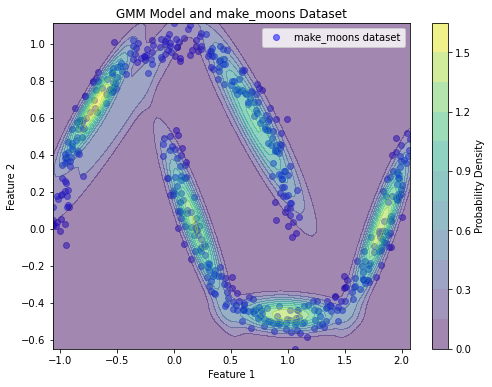

<Figure size 432x288 with 0 Axes>

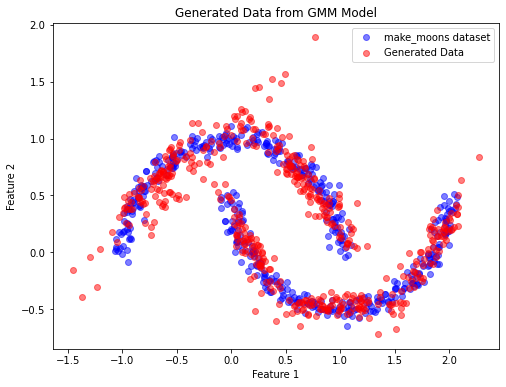

----------------DATASIZE: Large ------------------
index_el: 1
L is:
1
trained means are:
[[0.5006108  0.24937081]]
trained_covs are:
{0: array([[ 0.75409776, -0.19372119],
       [-0.19372119,  0.24760576]])}
trained_mixing_coeffs are:
[[1.]]


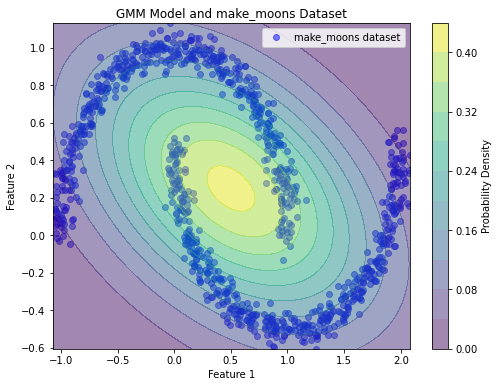

<Figure size 432x288 with 0 Axes>

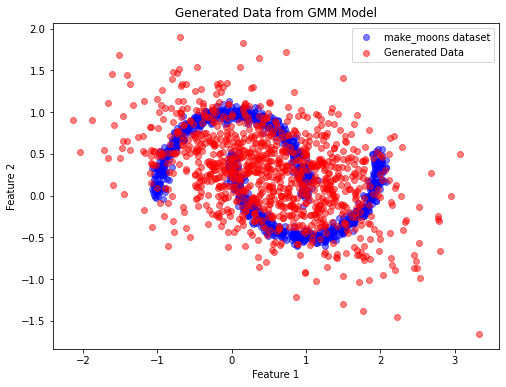

index_el: 2
L is:
2
trained means are:
[[ 1.08458603 -0.10711648]
 [-0.18302557  0.66669617]]
trained_covs are:
{0: array([[0.3719215 , 0.03322615],
       [0.03322615, 0.10677373]]), 1: array([[0.33491076, 0.06960715],
       [0.06960715, 0.08954053]])}
trained_mixing_coeffs are:
[[0.53931059 0.46068941]]


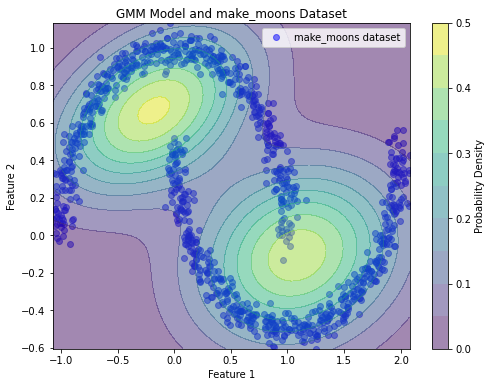

<Figure size 432x288 with 0 Axes>

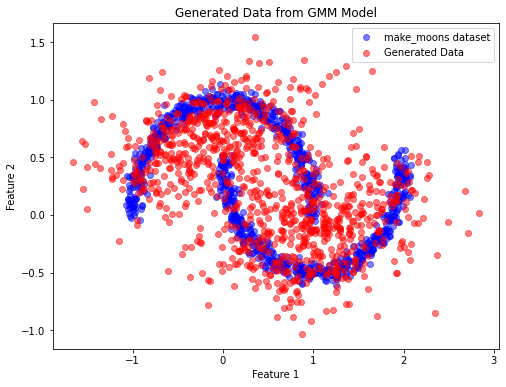

index_el: 3
L is:
3
trained means are:
[[0.52360769 0.29470059]
 [0.4931203  0.23513713]
 [0.50350186 0.25469662]]
trained_covs are:
{0: array([[ 0.75284999, -0.19469772],
       [-0.19469772,  0.24567565]]), 1: array([[ 0.75432553, -0.19378929],
       [-0.19378929,  0.2473466 ]]), 2: array([[ 0.75396411, -0.19377042],
       [-0.19377042,  0.24760428]])}
trained_mixing_coeffs are:
[[0.0570443  0.38895735 0.55399836]]


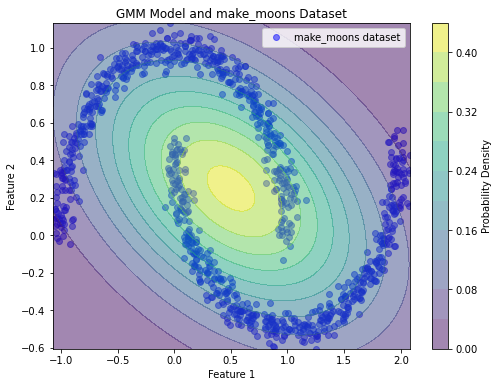

<Figure size 432x288 with 0 Axes>

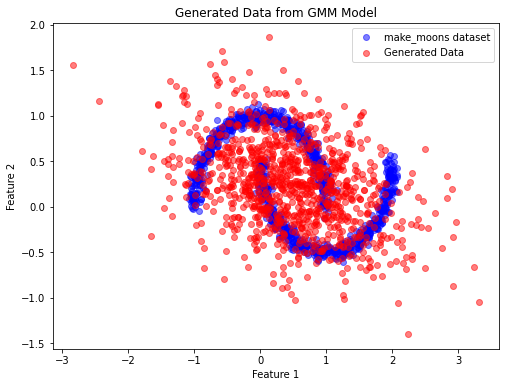

index_el: 4
L is:
4
trained means are:
[[ 0.39015264 -0.14920098]
 [-0.62858292  0.64012578]
 [ 1.6706995  -0.12047759]
 [ 0.64566914  0.6293827 ]]
trained_covs are:
{0: array([[ 0.11213506, -0.09305014],
       [-0.09305014,  0.0987731 ]]), 1: array([[0.10219888, 0.0894699 ],
       [0.0894699 , 0.09920324]]), 2: array([[0.07941799, 0.07950122],
       [0.07950122, 0.09922592]]), 3: array([[ 0.09676337, -0.08748036],
       [-0.08748036,  0.09932287]])}
trained_mixing_coeffs are:
[[0.26248743 0.25253636 0.23785295 0.24712327]]


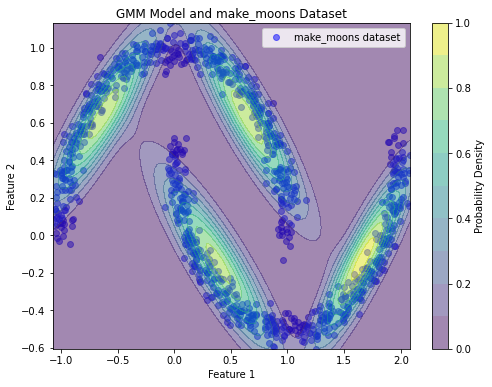

<Figure size 432x288 with 0 Axes>

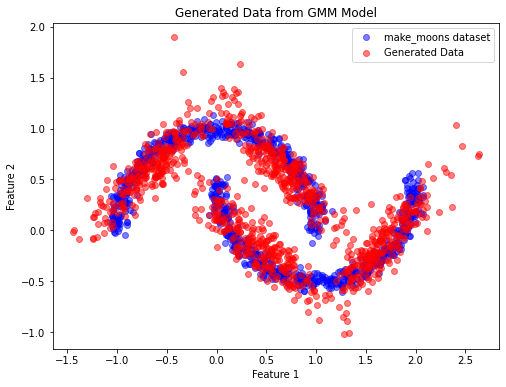

index_el: 5
L is:
5
trained means are:
[[ 1.72287556 -0.08197237]
 [ 0.55711357  0.37277763]
 [ 0.63539353 -0.36376739]
 [-0.00272765  0.94688566]
 [-0.84278331  0.45891133]]
trained_covs are:
{0: array([[0.05768215, 0.06523843],
       [0.06523843, 0.09176034]]), 1: array([[0.16162401, 0.0158288 ],
       [0.0158288 , 0.0702885 ]]), 2: array([[ 0.10694075, -0.04277612],
       [-0.04277612,  0.02281077]]), 3: array([[0.10573988, 0.00041779],
       [0.00041779, 0.00406111]]), 4: array([[0.02208103, 0.03396911],
       [0.03396911, 0.06667171]])}
trained_mixing_coeffs are:
[[0.21521201 0.25369938 0.19305924 0.17939865 0.15863073]]


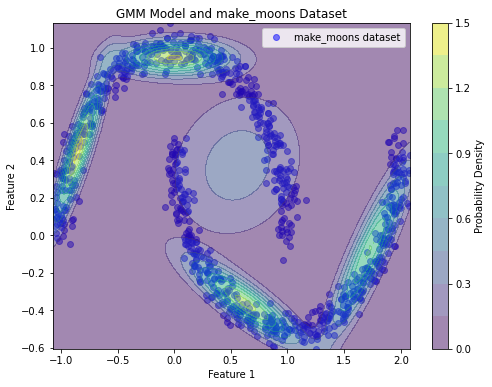

<Figure size 432x288 with 0 Axes>

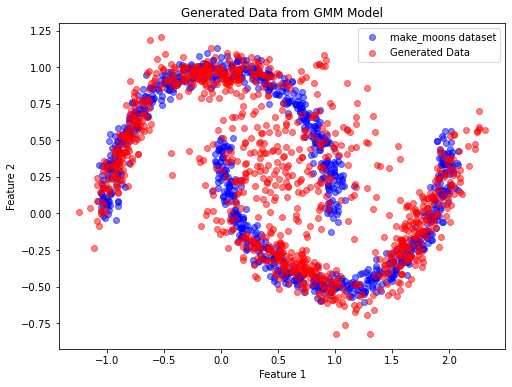

index_el: 6
L is:
6
trained means are:
[[ 1.80795405e+00  5.94339442e-04]
 [-2.97066983e-02  9.48929517e-01]
 [-8.45207084e-01  4.55530091e-01]
 [ 9.68410407e-01 -4.61172484e-01]
 [ 8.28995146e-01  4.72608999e-01]
 [ 1.75411880e-01  2.26493671e-02]]
trained_covs are:
{0: array([[0.02947833, 0.04161469],
       [0.04161469, 0.0756732 ]]), 1: array([[0.09670783, 0.00270389],
       [0.00270389, 0.00402604]]), 2: array([[0.02149688, 0.03327045],
       [0.03327045, 0.0659618 ]]), 3: array([[ 0.08520695, -0.00424247],
       [-0.00424247,  0.00329462]]), 4: array([[ 0.02846508, -0.03996603],
       [-0.03996603,  0.0731857 ]]), 5: array([[ 0.0256923 , -0.03644078],
       [-0.03644078,  0.06785829]])}
trained_mixing_coeffs are:
[[0.17657935 0.17513429 0.15750007 0.15596407 0.16817636 0.16664586]]


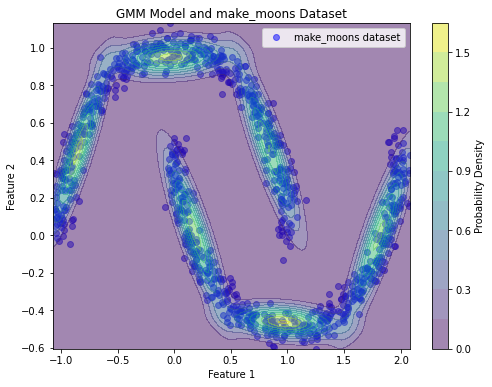

<Figure size 432x288 with 0 Axes>

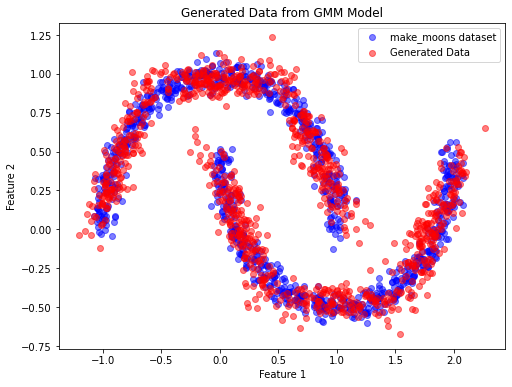

In [ ]:
### fit the GMM model to the data and then sample

dataset_for_GMM={}; keys_dataset=list(datasets.keys())
for data_size in keys_dataset:
  print("----------------DATASIZE:",data_size,"------------------")
  #print("_________________________________________________________")
  X=datasets[data_size];temp={}
  for idx_el in range(1,7):
    print("index_el:",idx_el)
    trained_means, trained_covs, trained_mixing_coeffs=fit_the_GMM(X=X, L=idx_el)

    generated_samples=sample_from_gmm(num_samples=X.shape[0],mixing_coeffs=trained_mixing_coeffs,
                                          mean_array=trained_means,
                                          covs=trained_covs,
                                      X=X, want_scatter_plot=True)
    temp[idx_el]=generated_samples
  dataset_for_GMM[data_size]=temp

In [ ]:
# with open('GMM_dataset_dictionary.pkl', 'wb') as f:
#     pickle.dump(dataset_for_GMM, f)

Observations:

1.  For the given data-set, increasing the number of mixers in our GMM model helps in learning the distribution, something we would expect as the dataset is clearly not uni-modal so to speak.

2. As can clearly be seen, for a particular L (number of mixer components in the GMM), more the number of dataset, better is the estimate of the probability. With larger dataset, a GMM model of low value of L (less number of mixtures) is able to model the distribution as good as a GMM model with large l trained over low number of data-points.

This can also be seen more explicitly from the plot of $mmd^{2}$ for different L for each dataset of different sizes ('small':100 data points, 'medium':500 data points, 'high':1000 datapoints) plotted below!

## 1.4 Kernel density estimation.

Note that the kernel density estimation model is a non-parametric model, hence it does not require any "training" so to speak!


* discusses how to choose an appropriate bandwidth parameter: https://stats.libretexts.org/Bookshelves/Computing_and_Modeling/Supplemental_Modules_(Computing_and_Modeling)/Regression_Analysis/Nonparametric_Inference_-_Kernel_Density_Estimation#:~:text=Contributors-,Introduction%20and%20definition,%E2%88%88%CE%98%E2%8A%82Rd%7D.

* Squared exponential kernel:
https://www.mathworks.com/help/stats/kernel-covariance-function-options.html

In [ ]:
def squared_exp_kernel(xa:np.array, xb:np.array,bandwidth:float,amplitude:float=1):
  '''
  xa=row vector of shape (1xdimn_of_the_prob)
  xb= row vector of shape (1X dimn_of_the_prob)
  bandwidth: a hyperparameter
  amplitude: overall variance (set to 1 in the lecture, can be changed as well)
  '''
  diff=xa-xb
  kernel=(amplitude**2) *  np.exp( -np.dot(diff,diff)/(2*bandwidth) )### what we are calling bandwidth is also refered to as sigma^2 is some of the literature. Here we have followed the notation followed in the lecture
  return kernel

def inverse_multi_quadratic_kernel(xa:np.array, xb:np.array,bandwidth:float):
  '''
  xa=row vector of shape (1xdimn_of_the_prob)
  xb= row vector of shape (1X dimn_of_the_prob)
  bandwidth: a hyperparameter
  '''
  diff=xa-xb
  kernel=bandwidth/(bandwidth+ ((norm(diff))**2) )
  return kernel

def kernel_density_estimator(x:np.array, dataset:np.array, bandwidth:float, kernel_fn):
  '''
  x: a row vector (1X dimn of the problem) at which one wants to evaluate the KDE (prob function)
  dataset= an array of shape (N X dimn of the problem)
  bandwidth: hyperparameter
  kernel_fn: choice of the user
  '''
  num_data=np.shape(dataset)[0]
  list_kernel=[kernel_fn(xa=x,xb=dataset[j,:],bandwidth=bandwidth) for j in range(0,num_data)]
  prob=(1./num_data)*sum(list_kernel)## sometimes instead of 1./num_data , we also have 1./(bandwidth X num_data)
  return prob

In [ ]:
def estimate_bandwidth_with_silverman_rule(data):
    # Step 1: Calculate the standard deviation
    std_dev = np.std(data)

    # Step 2: Calculate the interquartile range (IQR)
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    # Step 3: Estimate the bandwidth using Silverman's rule of thumb
    n = len(data)
    bandwidth = 0.9 * min(std_dev, np.mean(IQR) / 1.34) * n ** (-1 / 5)

    return bandwidth

In [ ]:
# contour plot kde
def contour_plot_kde(X,bandwidth,xmin=-2,xmax=2,ymin=-1.5,ymax=1.5):

  # # Create a grid of points within the specified range
  x_grid = np.linspace(xmin, xmax, 100)
  y_grid = np.linspace(ymin, ymax, 100)
  X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
  points = np.c_[X_grid.ravel(), Y_grid.ravel()]

  # Evaluate the KDE at each point in the grid
  kde_values = np.array([kernel_density_estimator(point, X, bandwidth,kernel_fn=squared_exp_kernel) for point in points])
  kde_values = kde_values.reshape(X_grid.shape)

  # Create a contour plot
  plt.figure(figsize=(8, 6))
  plt.contourf(X_grid, Y_grid, kde_values, levels=100, cmap='viridis')
  plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
  plt.colorbar(label='Probability Density')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title('Scatter Plot for data and Contour Plot of KDE Probability Density')
  plt.legend()
  plt.show()

# contour plot for distribution from the KDE
# xmin, xmax = -1, 2  # Adjust the range as needed
# ymin, ymax = -1, 1  # Adjust the range as needed
# # bandwidth =  estimate_bandwidth_with_silverman_rule(X)
# # print("Estimated bandwidth using silverman rule:", bandwidth)
# contour_plot_kde(X,bandwidth=0.1,xmin=-1,xmax=2,ymin=-1,ymax=1)


In [ ]:
### Sampling from the KDE
def sample_from_kde(data, bandwidth, num_samples,want_scatter_plot=False):
  samples = []
  for _ in range(num_samples):
      # Randomly select a data point
      data_point = data[np.random.randint(len(data))]

      # Generate random perturbations based on the Gaussian kernel
      perturbations = np.random.normal(0, bandwidth, size=data_point.shape)

      # Add the perturbations to the selected data point
      sample = data_point + perturbations
      samples.append(sample)

  samples=np.array(samples)

  if want_scatter_plot==True:
    # Sample from the KDE
    # visualise the original and the generated data
    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1,], c='b', label='Original Data')
    plt.scatter(samples[:, 0], samples[:, 1,], c='r', label='Generated Data')
    plt.legend()
    plt.tight_layout()
    plt.show()

  return samples

--------data_size: Small
bandwidth: 0.01


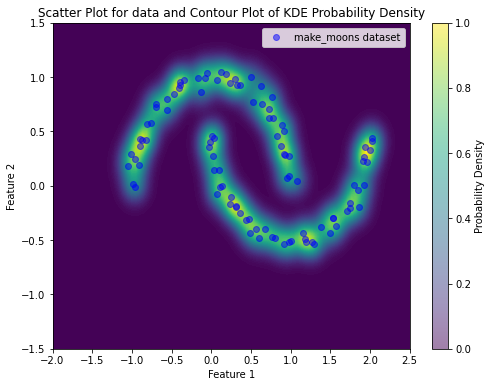

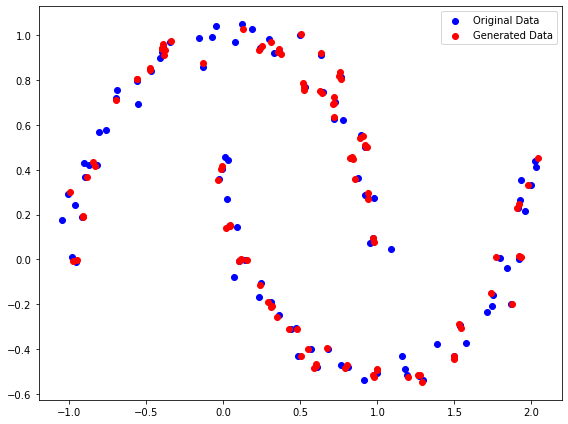

bandwidth: 0.05


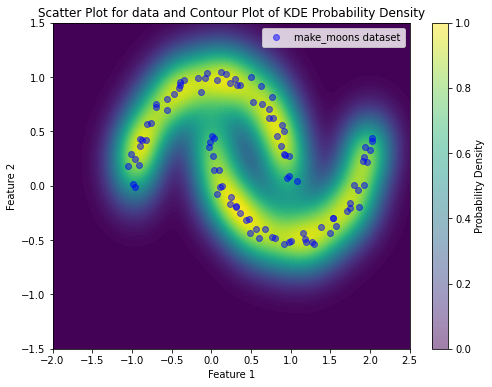

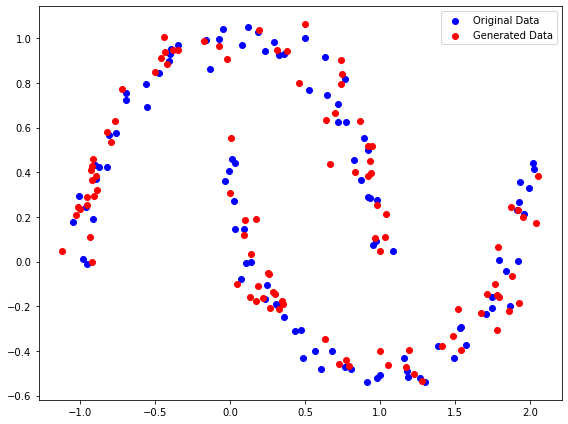

bandwidth: 0.1


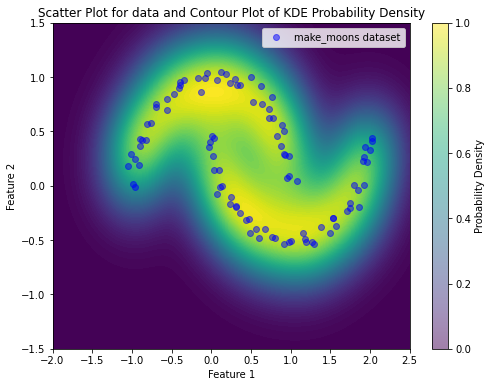

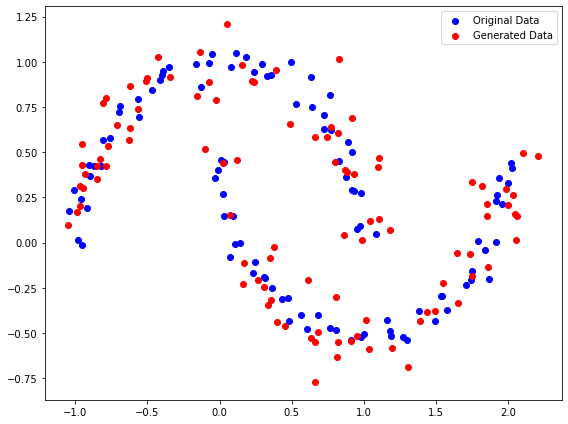

bandwidth: 0.15


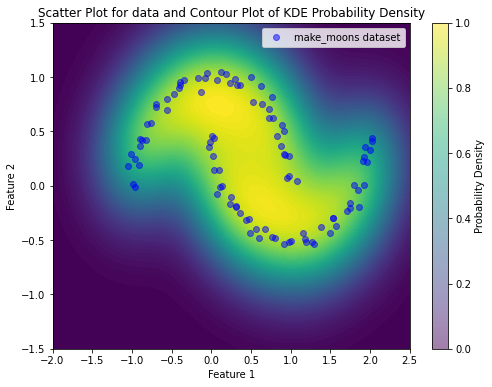

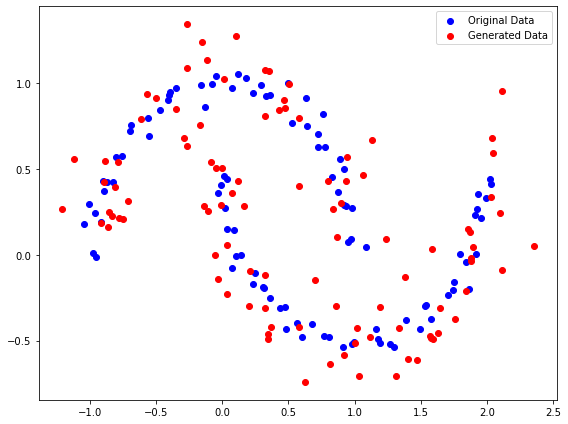

bandwidth: 0.2


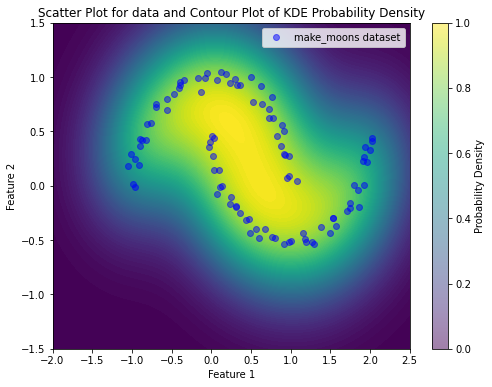

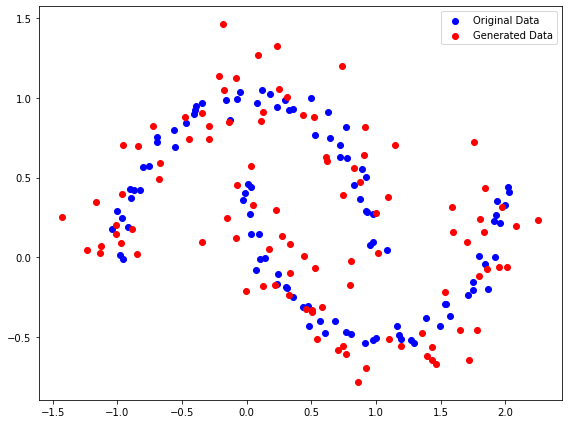

bandwidth: 0.25


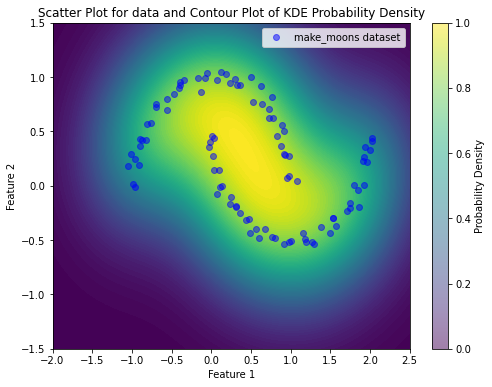

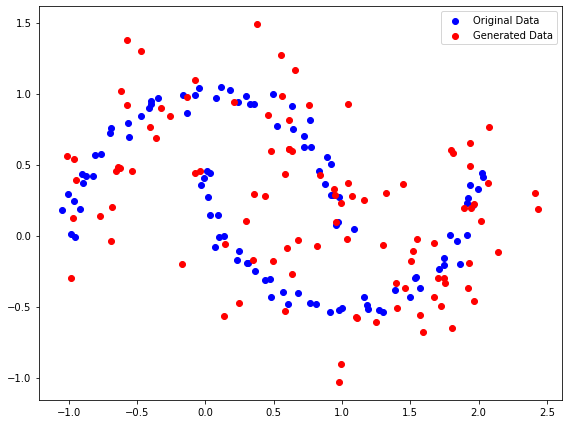

bandwidth: 0.3


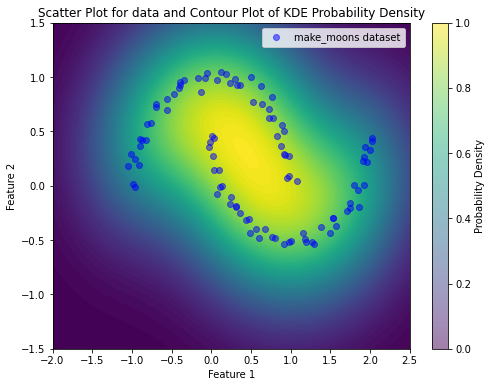

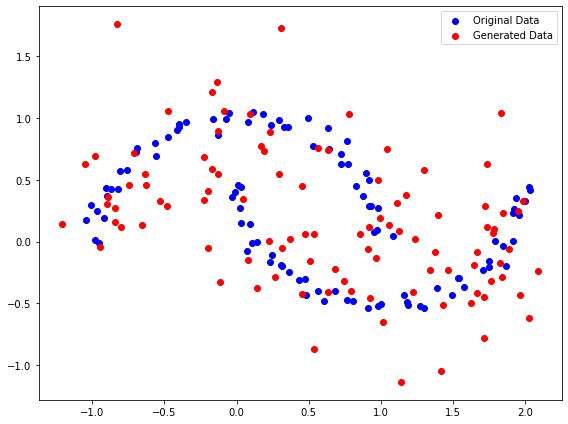

bandwidth: 0.35


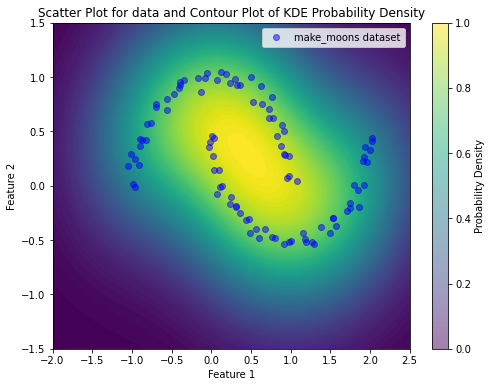

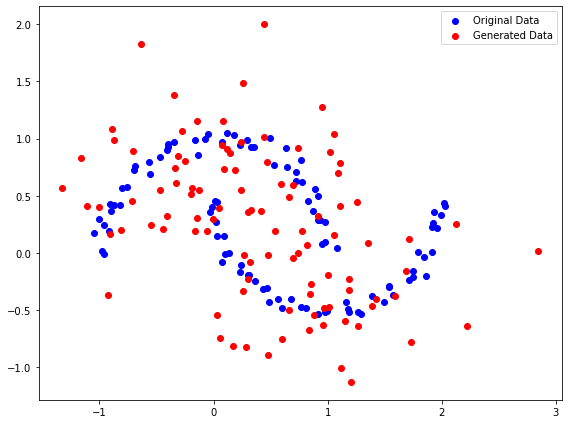

bandwidth: 0.4


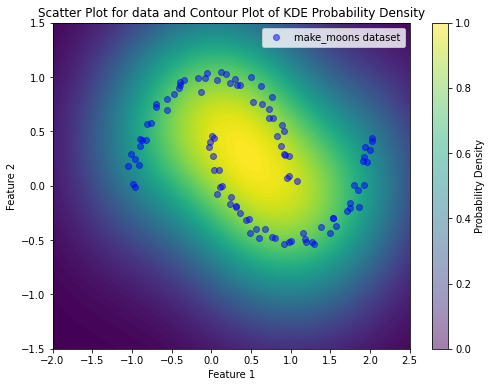

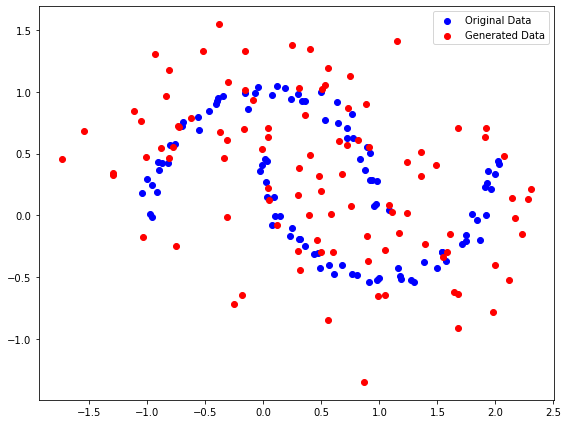

--------data_size: Medium
bandwidth: 0.01


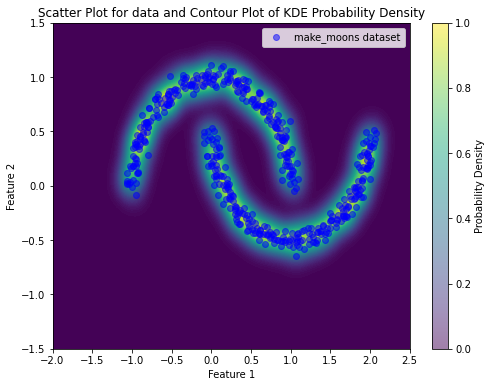

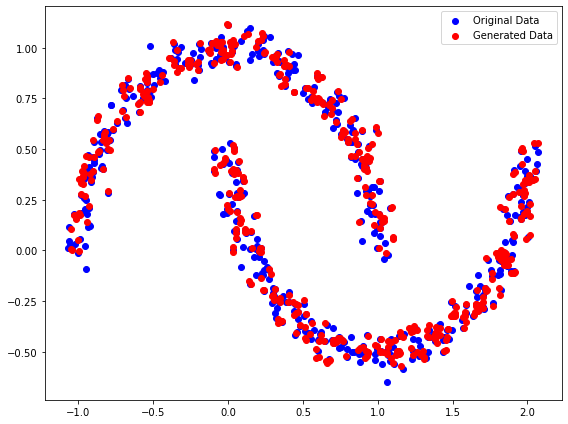

bandwidth: 0.05


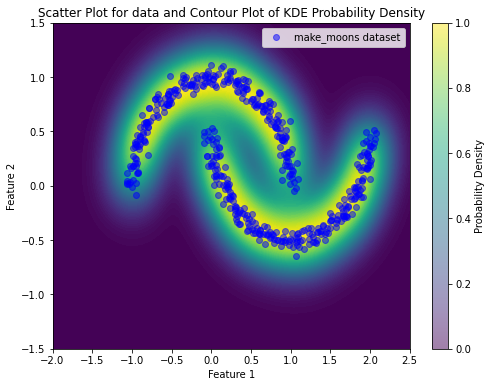

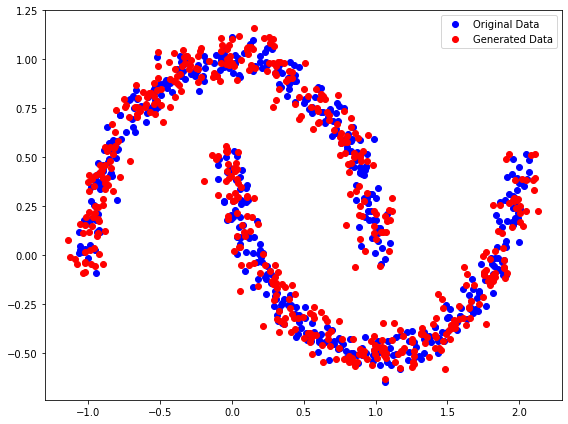

bandwidth: 0.1


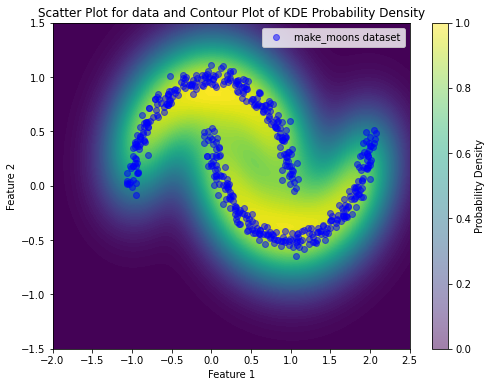

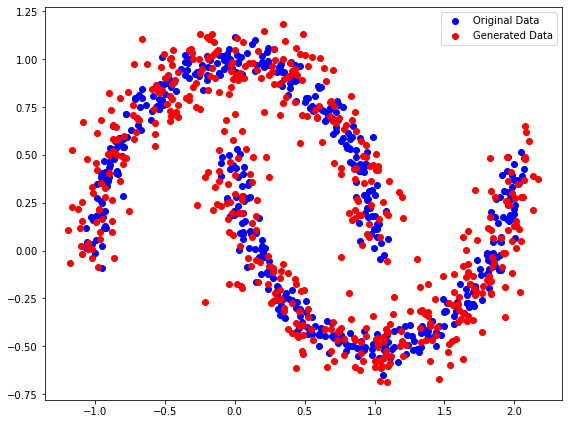

bandwidth: 0.15


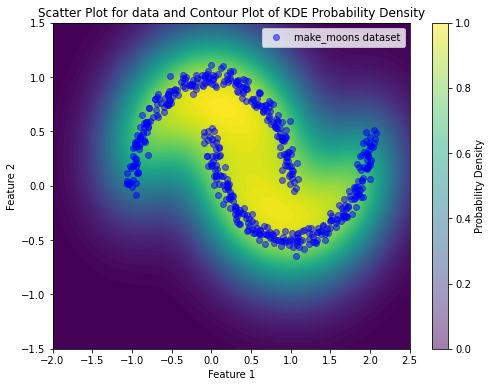

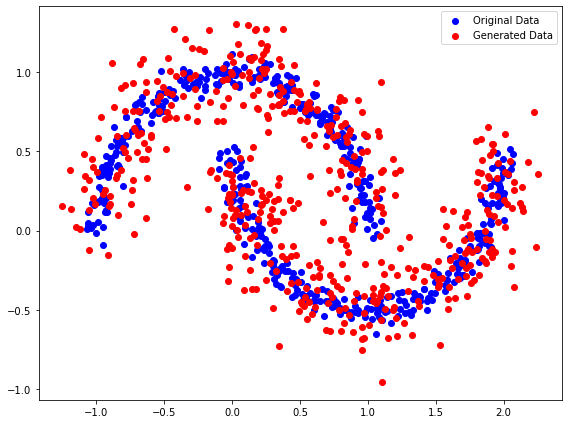

bandwidth: 0.2


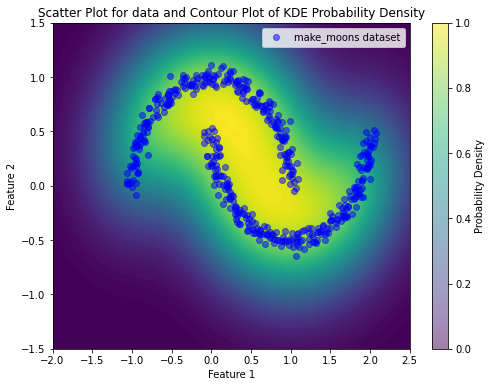

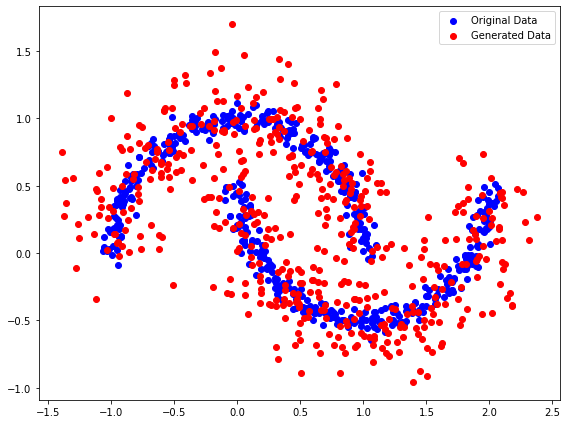

bandwidth: 0.25


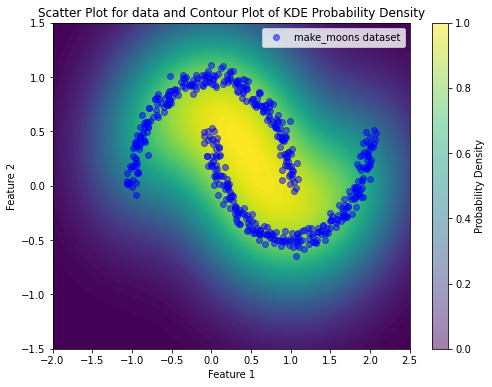

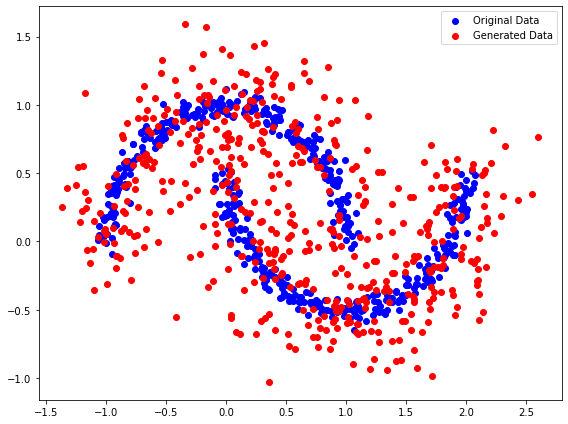

bandwidth: 0.3


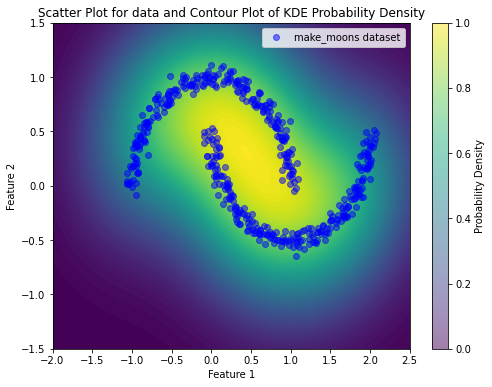

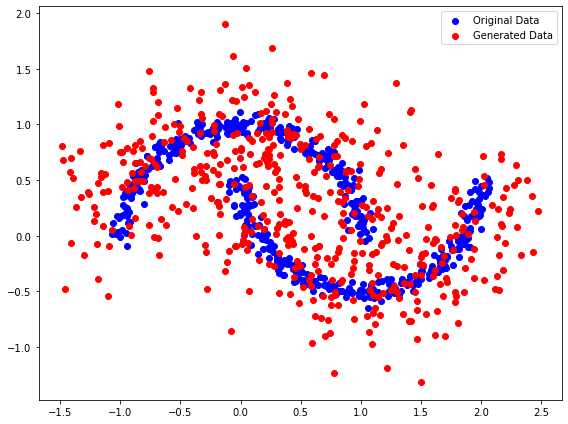

bandwidth: 0.35


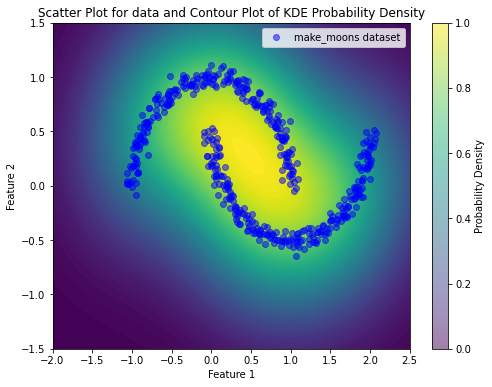

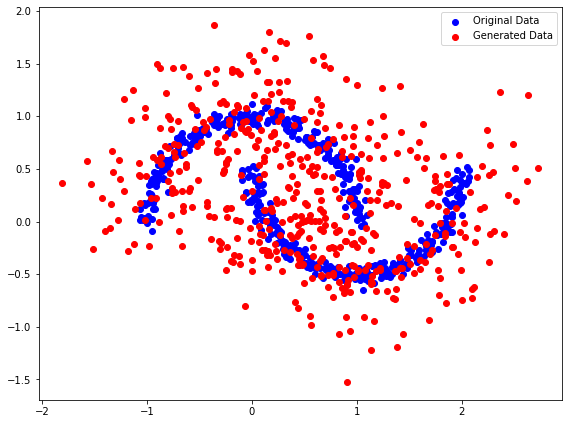

bandwidth: 0.4


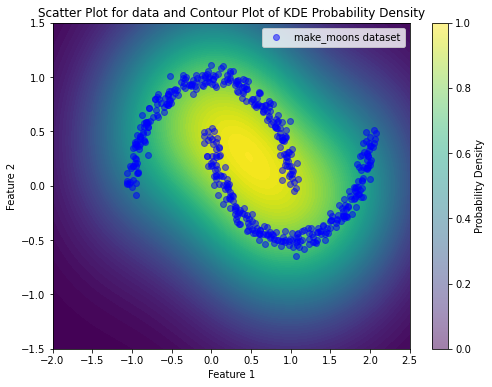

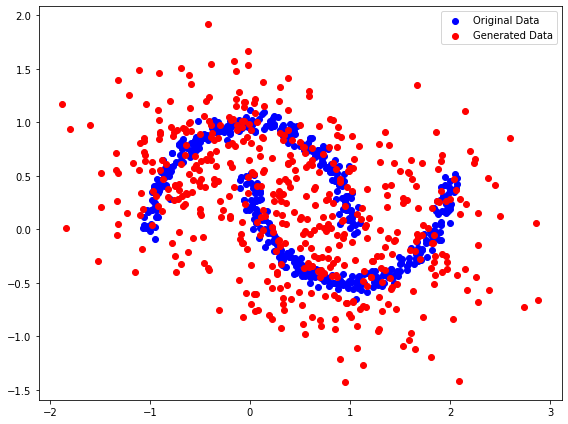

--------data_size: Large
bandwidth: 0.01


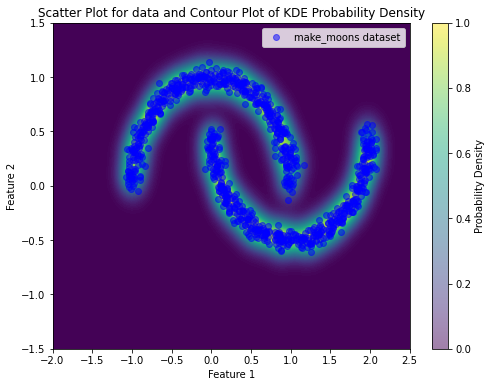

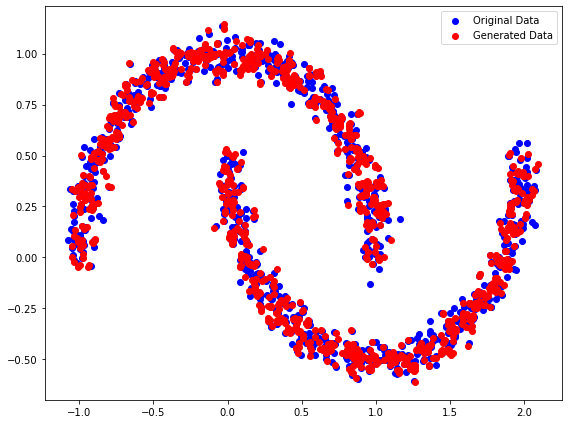

bandwidth: 0.05


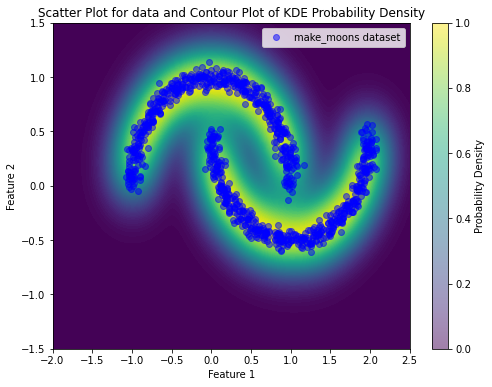

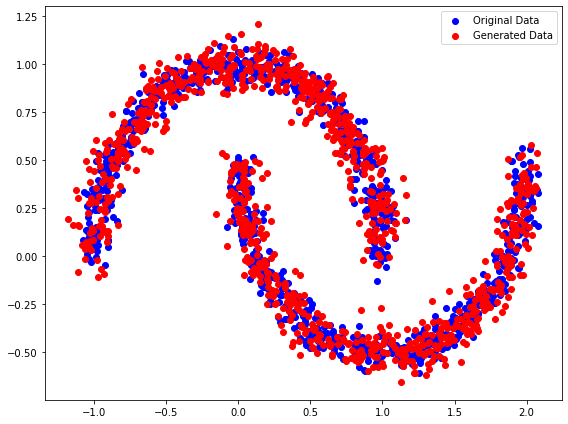

bandwidth: 0.1


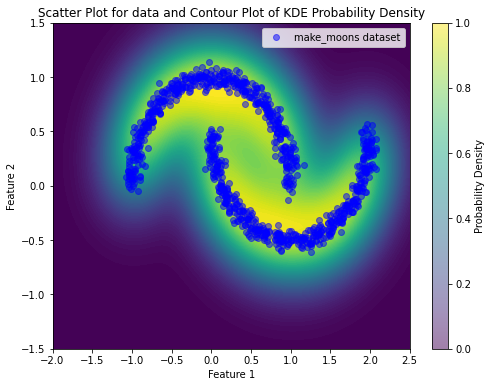

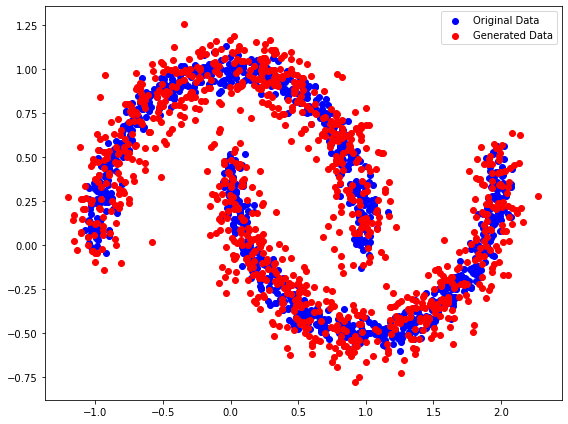

bandwidth: 0.15


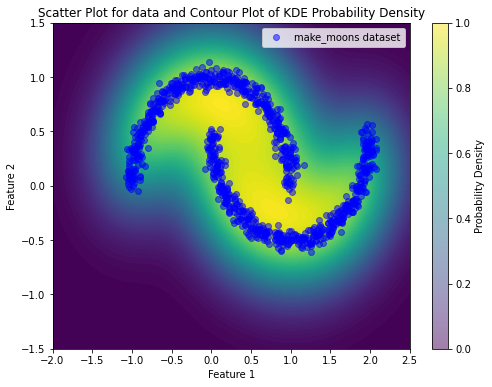

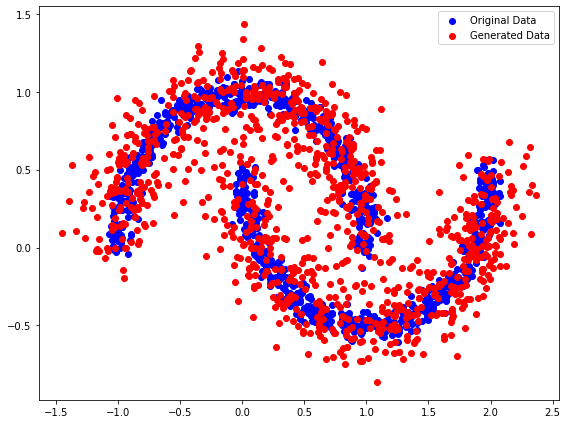

bandwidth: 0.2


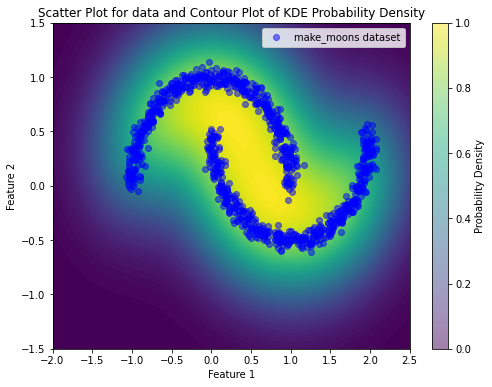

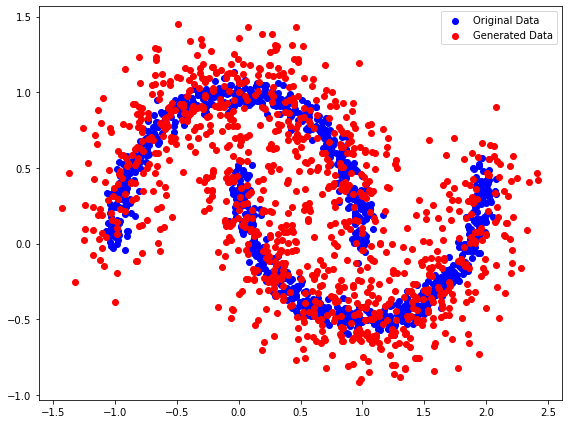

bandwidth: 0.25


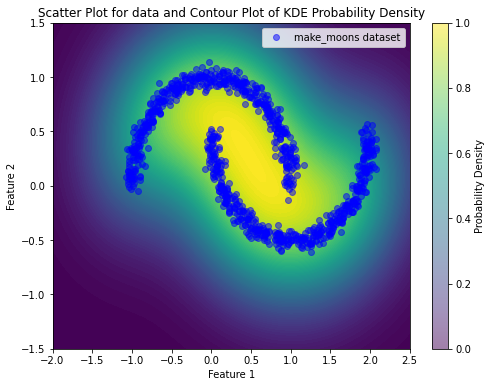

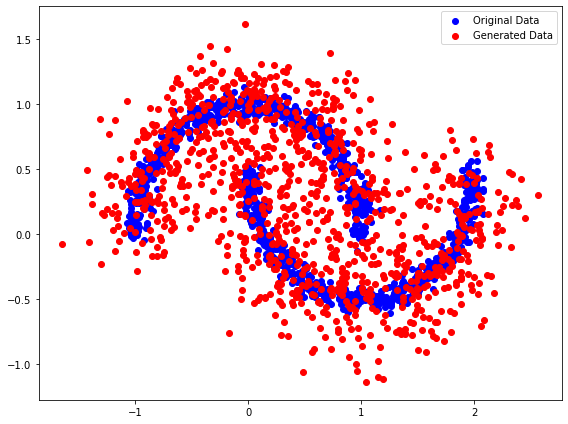

bandwidth: 0.3


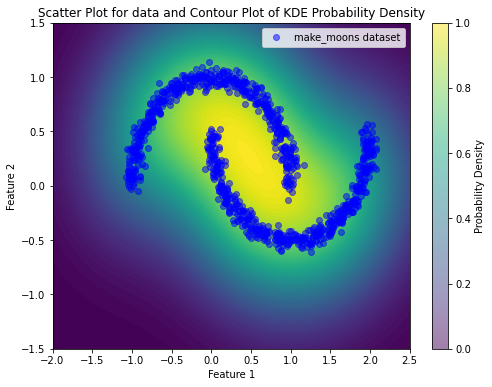

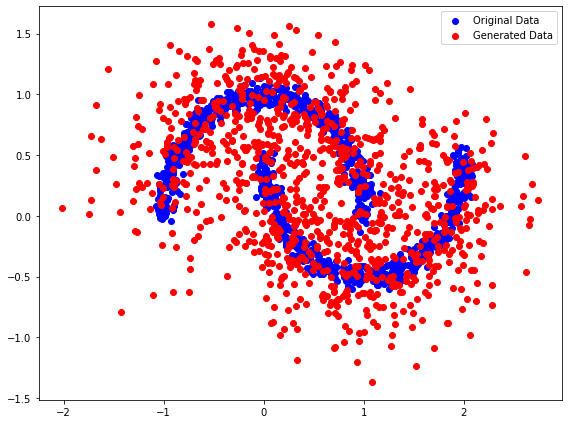

bandwidth: 0.35


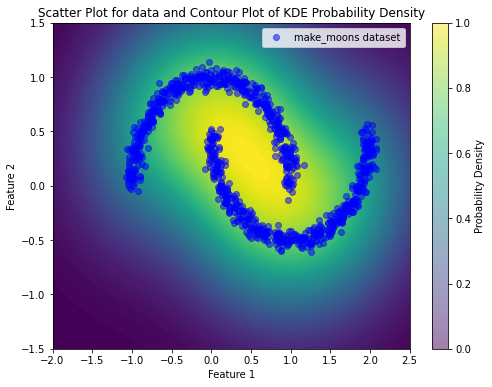

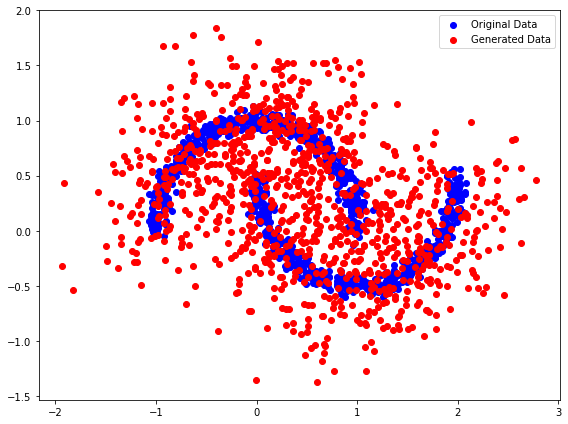

bandwidth: 0.4


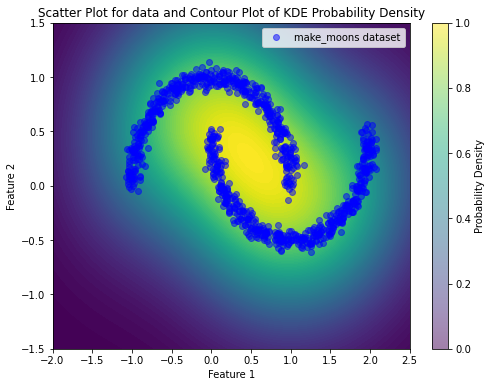

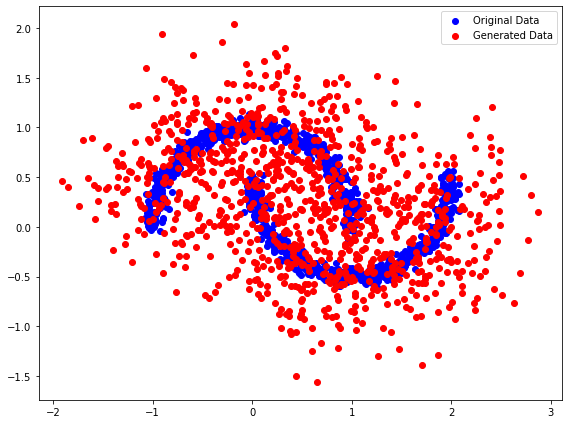

In [ ]:
dataset_kde={};bandwidth=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4];keys_dataset=list(datasets.keys())
keys_dataset=list(datasets.keys())
for data_size in keys_dataset:
  print("--------data_size:",data_size)
  X=datasets[data_size];temp={}
  for bw in bandwidth:
    print("bandwidth:",bw)
    contour_plot_kde(X,bandwidth=bw,xmin=-2,xmax=2.5,ymin=-1.5,ymax=1.5)
    generated_data_KDE=sample_from_kde(data=X,bandwidth=bw,num_samples=X.shape[0],want_scatter_plot=True)
    temp[bw]=generated_data_KDE
  dataset_kde[data_size]=temp

In [ ]:
# with open('KDE_dataset_dictionary_smaller_bw_range.pkl', 'wb') as f:
#     pickle.dump(dataset_kde, f)

### Implementation of MMD metric:

a good resource for MMD: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html

In [ ]:
import numpy as np

def estimate_mmd_squared(samples1, samples2, kernel_function, bandwidth=1.0):
    """
    Estimate the Maximum Mean Discrepancy (MMD) squared between two sets of samples using a kernel function.

    Args:
    - samples1: the first set of samples.
                A numpy array of shape (n_samples1, n_features) representing .
    - samples2: the second set of samples.
                A numpy array of shape (n_samples2, n_features) representing .
    - kernel_function: A function that computes the kernel value between two samples.
    - bandwidth: Bandwidth parameter for the kernel function.

    Returns:
    - mmd_squared: The estimated MMD squared.
    """
    num_samples1 = samples1.shape[0]
    num_samples2 = samples2.shape[0]

    # Compute the MMD squared statistic
    mmd_squared1,mmd_squared2,mmd_squared12 = 0.0,0.0,0.0

    for i in range(num_samples1):
        for j in range(num_samples1):
            mmd_squared1 += kernel_function(samples1[i], samples1[j], bandwidth)
    mmd_squared1 *= 1.0 / (num_samples1 * (num_samples1 - 1))

    for i in range(num_samples2):
        for j in range(num_samples2):
            mmd_squared2 += kernel_function(samples2[i], samples2[j], bandwidth)
    mmd_squared2 *= 1.0 / (num_samples2 * (num_samples2 - 1))

    for i in range(num_samples1):
        for j in range(num_samples2):
            mmd_squared12 -= 2.0 * kernel_function(samples1[i], samples2[j], bandwidth)
    mmd_squared12 *= 1.0 / (num_samples1 * (num_samples2))

    mmd_squared=mmd_squared1+mmd_squared2+mmd_squared12


    return mmd_squared

def squared_exp_kernel(xa, xb, bandwidth, amplitude=1.0):
    """
    Squared Exponential (RBF) kernel function.

    Args:
    - xa: A numpy array of shape (1, dimn_of_the_prob).
    - xb: A numpy array of shape (1, dimn_of_the_prob).
    - bandwidth: Bandwidth parameter.
    - amplitude: Overall variance (default is 1).

    Returns:
    - kernel: The kernel value.
    """
    diff = xa - xb
    kernel = (amplitude ** 2) * np.exp(-np.dot(diff, diff) / (2 * bandwidth))
    return kernel

def inverse_multi_quadratic_kernel(xa, xb, bandwidth):
    """
    Inverse Multi-Quadratic kernel function.

    Args:
    - xa: A numpy array of shape (1, dimn_of_the_prob).
    - xb: A numpy array of shape (1, dimn_of_the_prob).
    - bandwidth: Bandwidth parameter.

    Returns:
    - kernel: The kernel value.
    """
    diff = xa - xb
    kernel = bandwidth / (bandwidth + np.sum(diff ** 2))
    return kernel

In [ ]:
def plot_dict_of_dicts(data, x_label='X-values', y_label='Y-values', title='Two-Line Point Plot'):
    """
    Plot a dictionary of dictionaries as separate lines on a two-line point plot.

    Args:
        data (dict): A dictionary where keys represent labels and values are dictionaries with x and y values.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title for the plot.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))

    for label, values in data.items():
        x_values = list(values.keys())
        y_values = list(values.values())
        plt.plot(x_values, y_values,":" ,marker='o', label=label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Using squared exponential kernel to estimate the MMD.

### evaluating mmds for GMMs using squared exponential kernel

In [ ]:
size_dataset=["Small","Medium","Large"];mmd_gmm_model_sqd_exp_kernel={}
for data_size in size_dataset:
  print("----------------DATASIZE:",data_size,"------------------")
  X=datasets[data_size];
  temp={}
  for idx_el in range(1,7):
    dataset_sampled_gmm=dataset_for_GMM[data_size][idx_el]
    temp[idx_el]=estimate_mmd_squared(samples1=dataset_sampled_gmm,
                                           samples2=X, kernel_function=squared_exp_kernel)
    print("for L=",idx_el," MMD^2 score:");print(temp[idx_el])
  mmd_gmm_model_sqd_exp_kernel[data_size]=temp


----------------DATASIZE: Small ------------------
for L= 1  MMD^2 score:
0.01798527927664728
for L= 2  MMD^2 score:
0.01585413528597379
for L= 3  MMD^2 score:
0.014333589840465732
for L= 4  MMD^2 score:
0.01885141362157783
for L= 5  MMD^2 score:
0.017111986131505663
for L= 6  MMD^2 score:
0.01424441214263572
----------------DATASIZE: Medium ------------------
for L= 1  MMD^2 score:
0.014711949787886258
for L= 2  MMD^2 score:
0.007262642636953309
for L= 3  MMD^2 score:
0.008464372911981988
for L= 4  MMD^2 score:
0.0033090778972904022
for L= 5  MMD^2 score:
0.0037458278832058767
for L= 6  MMD^2 score:
0.0029070947795684088
----------------DATASIZE: Large ------------------
for L= 1  MMD^2 score:
0.0053225840766861765
for L= 2  MMD^2 score:
0.00293290588396089
for L= 3  MMD^2 score:
0.009370856529772764
for L= 4  MMD^2 score:
0.0012897234645621314
for L= 5  MMD^2 score:
0.001181141331244584
for L= 6  MMD^2 score:
0.0014965479211841437


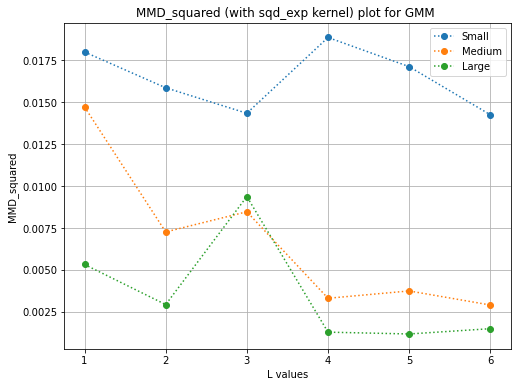

In [ ]:
plot_dict_of_dicts(data=mmd_gmm_model_sqd_exp_kernel,
                   x_label="L values",
                   y_label="MMD_squared",
                   title="MMD_squared (with sqd_exp kernel) plot for GMM for dataset of different lengths ")

### evaluating mmds for KDEs using squared exponential kernel

In [ ]:
mmd_kde_model_sqd_exp_kernel={}
bandwidth_for_kde=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4];keys_dataset=list(datasets.keys())
size_dataset=["Small","Medium","Large"]
for data_size in size_dataset:
  print("--------Data_size:",data_size,"-----------")
  X=datasets[data_size];temp={}
  for bw in bandwidth_for_kde:
    dataset_sampled_kde=dataset_kde[data_size][bw]
    temp[bw]=estimate_mmd_squared(samples1=dataset_sampled_kde,
                                           samples2=X, kernel_function=squared_exp_kernel)
    print("for bandwidth:",bw," MMD^2 score:",temp[bw])
  mmd_kde_model_sqd_exp_kernel[data_size]=temp

--------Data_size: Small -----------
for bandwidth: 0.01  MMD^2 score: 0.01743045831984813
for bandwidth: 0.05  MMD^2 score: 0.012653917167822604
for bandwidth: 0.1  MMD^2 score: 0.013074194236957215
for bandwidth: 0.15  MMD^2 score: 0.011987219379957503
for bandwidth: 0.2  MMD^2 score: 0.011741998925491659
for bandwidth: 0.25  MMD^2 score: 0.029023763261676994
for bandwidth: 0.3  MMD^2 score: 0.017922526926156035
for bandwidth: 0.35  MMD^2 score: 0.018401240343025815
for bandwidth: 0.4  MMD^2 score: 0.017502329498561897
--------Data_size: Medium -----------
for bandwidth: 0.01  MMD^2 score: 0.004343969429631223
for bandwidth: 0.05  MMD^2 score: 0.0031895588040529166
for bandwidth: 0.1  MMD^2 score: 0.002771428793961861
for bandwidth: 0.15  MMD^2 score: 0.00310367098708908
for bandwidth: 0.2  MMD^2 score: 0.0033878079304349162
for bandwidth: 0.25  MMD^2 score: 0.005339315357050456
for bandwidth: 0.3  MMD^2 score: 0.004950104579540704
for bandwidth: 0.35  MMD^2 score: 0.0068071291151882

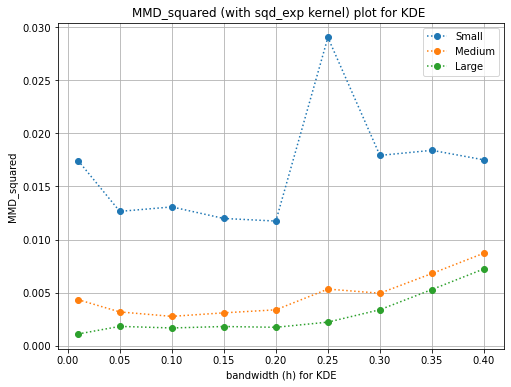

In [ ]:
plot_dict_of_dicts(data=mmd_kde_model_sqd_exp_kernel,
                   x_label="bandwidth (h) for KDE",
                   y_label="MMD_squared",
                   title="MMD_squared (with sqd_exp kernel) plot for KDE for dataset of different lengths ")

### Evaluating MMDS using inverse multi-quadratic fn
for GMM

In [ ]:
size_dataset=["Small","Medium","Large"];mmd_gmm_model_inv_quad={}
for data_size in size_dataset:
  print("----------------DATASIZE:",data_size,"------------------")
  X=datasets[data_size];
  temp={}
  for idx_el in range(1,7):
    print("L:",idx_el)
    dataset_sampled_gmm=dataset_for_GMM[data_size][idx_el]
    temp[idx_el]=estimate_mmd_squared(samples1=dataset_sampled_gmm,
                                           samples2=X, kernel_function=inverse_multi_quadratic_kernel)
    print("For L=",idx_el," MMD^2 score:",temp[idx_el])
  mmd_gmm_model_inv_quad[data_size]=temp

----------------DATASIZE: Small ------------------
L: 1
For L= 1  MMD^2 score: 0.02601085913234058
L: 2
For L= 2  MMD^2 score: 0.020805545804002068
L: 3
For L= 3  MMD^2 score: 0.01681661351375563
L: 4
For L= 4  MMD^2 score: 0.021384277697487297
L: 5
For L= 5  MMD^2 score: 0.017366758933550108
L: 6
For L= 6  MMD^2 score: 0.014467606517708065
----------------DATASIZE: Medium ------------------
L: 1
For L= 1  MMD^2 score: 0.01961415065976224
L: 2
For L= 2  MMD^2 score: 0.011884780347332535
L: 3
For L= 3  MMD^2 score: 0.010747288212260897
L: 4
For L= 4  MMD^2 score: 0.004853595520703191
L: 5
For L= 5  MMD^2 score: 0.0046109599821620995
L: 6
For L= 6  MMD^2 score: 0.0031093046306518435
----------------DATASIZE: Large ------------------
L: 1
For L= 1  MMD^2 score: 0.01085610763364886
L: 2
For L= 2  MMD^2 score: 0.0049311939977966235
L: 3
For L= 3  MMD^2 score: 0.01530502906704212
L: 4
For L= 4  MMD^2 score: 0.0022761777146537154
L: 5
For L= 5  MMD^2 score: 0.0017360520528008072
L: 6
For L= 6

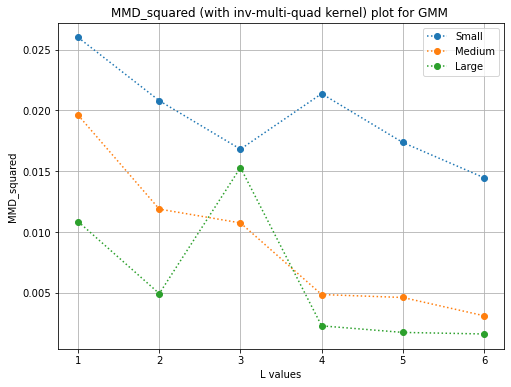

In [ ]:
plot_dict_of_dicts(data=mmd_gmm_model_inv_quad,
                   x_label="L values",
                   y_label="MMD_squared",
                   title="MMD_squared (with inv-multi-quad kernel) plot for GMM for dataset of different lengths")

for KDE:

In [ ]:
mmd_kde_model_inv_quad={}
bandwidth_for_kde=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4];keys_dataset=list(datasets.keys())
size_dataset=["Small","Medium","Large"]
for data_size in size_dataset:
  print("--------Data_size:",data_size,"-----------")
  X=datasets[data_size];temp={}
  for bw in bandwidth_for_kde:
    dataset_sampled_kde=dataset_kde[data_size][bw]
    temp[bw]=estimate_mmd_squared(samples1=dataset_sampled_kde,
                                           samples2=X, kernel_function=inverse_multi_quadratic_kernel)
    print("for bandwidth:",bw," MMD^2 score:",temp[bw])
  mmd_kde_model_inv_quad[data_size]=temp

--------Data_size: Small -----------
for bandwidth: 0.01  MMD^2 score: 0.017635552981687286
for bandwidth: 0.05  MMD^2 score: 0.0132964814393417
for bandwidth: 0.1  MMD^2 score: 0.013444108881843886
for bandwidth: 0.15  MMD^2 score: 0.012016885319301895
for bandwidth: 0.2  MMD^2 score: 0.011824997808379978
for bandwidth: 0.25  MMD^2 score: 0.026065432110628284
for bandwidth: 0.3  MMD^2 score: 0.018338758353038997
for bandwidth: 0.35  MMD^2 score: 0.019270415452906753
for bandwidth: 0.4  MMD^2 score: 0.01817369393947854
--------Data_size: Medium -----------
for bandwidth: 0.01  MMD^2 score: 0.0038915645092560958
for bandwidth: 0.05  MMD^2 score: 0.003072480910366271
for bandwidth: 0.1  MMD^2 score: 0.0028551683549469242
for bandwidth: 0.15  MMD^2 score: 0.003322040868382059
for bandwidth: 0.2  MMD^2 score: 0.003826470800430526
for bandwidth: 0.25  MMD^2 score: 0.00574687053617251
for bandwidth: 0.3  MMD^2 score: 0.005582476461801655
for bandwidth: 0.35  MMD^2 score: 0.0085865151738862
f

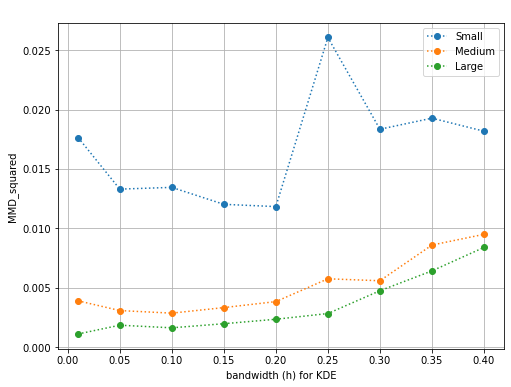

In [ ]:
plot_dict_of_dicts(data=mmd_kde_model_inv_quad,
                   x_label="bandwidth (h) for KDE",
                   y_label="MMD_squared",
                   title="MMD^{squared} (with inverse_multi_quadratic_kernel) for KDE for dataset of different lengths ")

### Generic observations:

1. In the case of both GMMs with small L (number of mixtures) and KDE with otherwise not good bandwidth (>0.25 in our case), having large number of data-points is favourable!

2. We expected (and as also can be seen from the plots above) the single gaussian to act the worse (as can be seen from l=1 case in the GMM) as our dataset is quite 'multimodal' so to speak which it clearly cannot capture.

# 2. Higher-dimensional data

## Loading and splitting the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Let's load the dataset and split in train and test set and analyze how well the digits are distributed:

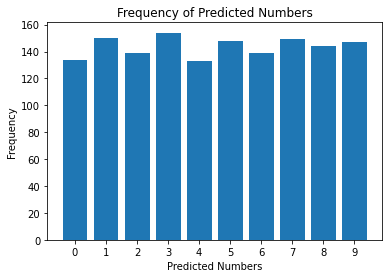

In [ ]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_train)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()


We see, that the digits are in evenly distributed frequency in the train dataset

## Define Maximum Mean Discrepancy

In [ ]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "rbf" or "inverse-multi-quadratic"
    """
    # Compute squared Euclidean distances

    xx, yy, zz = np.dot(x, x.T), np.dot(y, y.T), np.dot(x, y.T)
    rx = np.diag(xx).reshape(1, -1).repeat(xx.shape[0], axis=0)
    ry = np.diag(yy).reshape(1, -1).repeat(yy.shape[0], axis=0)

    dxx = rx.T + rx - 2. * xx  # Used for A in (1)
    dyy = ry.T + ry - 2. * yy  # Used for B in (1)
    dxy = rx.T + ry - 2. * zz  # Used for C in (1)

    XX, YY, XY = (np.zeros_like(xx),
                  np.zeros_like(xx),
                  np.zeros_like(xx))

    # Squared Exponential or Gaussian Kernel
    if kernel == "rbf":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(np.exp(-0.5 * dxx / a) for a in bandwidth_range)
        YY = sum(np.exp(-0.5 * dyy / a) for a in bandwidth_range)
        XY = sum(np.exp(-0.5 * dxy / a) for a in bandwidth_range)

    # Inverse Multi-Quadratic Kernel
    if kernel == "inverse-multi-quadratic":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(1 / (dxx / a + 1) for a in bandwidth_range)
        YY = sum(1 / (dyy / a + 1) for a in bandwidth_range)
        XY = sum(1 / (dxy / a + 1) for a in bandwidth_range)

    return np.mean(XX + YY - 2. * XY)

## Density Forest

As a first generative network we try to implement the Density Forest implemtation from https://github.com/kfritsch/density_forest


0.9857876261742521
0.9869981915860978
0.9629515202451933
0.9724714066439486
0.9762483707289074
[2.05270033 1.98594823]
[[ 0.28104953 -0.03427428]
 [-0.03427428  0.76206155]]
[7.92478726 7.99433023]
[[0.98950855 0.07043019]
 [0.07043019 0.45123263]]


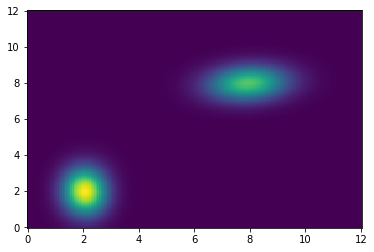

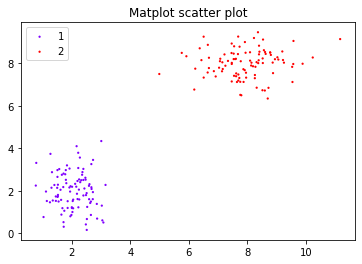

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 64

In [ ]:
from DensityForest import DensityForest
X = X_train
density_forest = DensityForest(n_estimators=20)
density_forest.fit(X)


After a few hours of bug fixing in the code, since it had semantic and syntax errors. We are now at a point, were the networks starts training, but we still run into an additional Error in the Node implementation. Since fixing the semantic error of the Node class and potential further errors and a seperate implementation of the sampling method would be over the scope of the first assignment we decided to skip the density forest implementation and will continue with the single gaussian.

## Single Gaussian
Now we implement a single Gaussian model, by using the 'GaussianMixture' model from scikit-learn with just one component

MMD with squared exponential kernel: 0.027863114876388897
MMD with inverse multi quadratic kernel: 0.03015763195614138


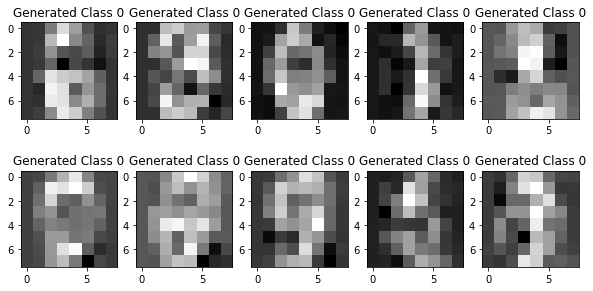

In [ ]:
n_components = 1
single_gaussian = GaussianMixture(n_components=n_components)
single_gaussian.fit(X_train)

new_samples, _ = single_gaussian.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

new_samples, _ = single_gaussian.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

We can see that the single Gaussian is already capable of generating number like images, with some samples  indicate legible numbers with higher noise. However, it clearly still lacks the capability to generate decent quality images in the majority of samples. Next, we will analyze the quality of generated dependend on the dataset size

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


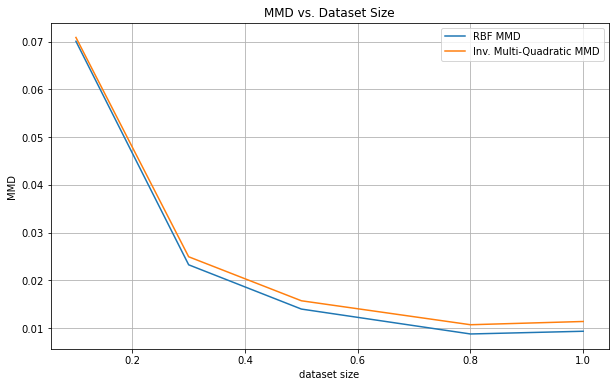

In [ ]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_gaussian = []
inv_gaussian = []
var_data_gaussian = GaussianMixture(n_components=1)

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)

    # Train the classifier on the current dataset size
    var_data_gaussian.fit(X)
    new_samples, _ = var_data_gaussian.sample(len(X))
    rbf_gaussian.append(MMD(X,new_samples, "rbf"))
    inv_gaussian.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_gaussian, label="RBF MMD")
plt.plot(dataset_sizes, inv_gaussian, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

We see, the model improves the more training data it uses

## Gaussian mixture model (GMM)
Let's continue with training a Gaussian mixture model (GMM) and start by using 50 gaussian components

MMD with squared exponential kernel: 0.027873892208302355
MMD with inverse multi quadratic kernel: 0.028409240039774637


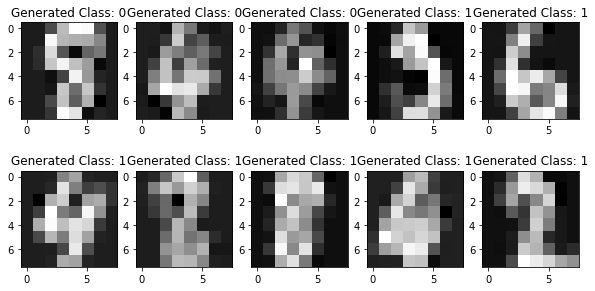

In [ ]:
n_components = 55
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_train)
new_samples, _ = gmm.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

# plot generated images
new_samples, _ = gmm.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

Now we investigate the hyperparameter number of components (n_components) in an grid search attempt to find a good fit

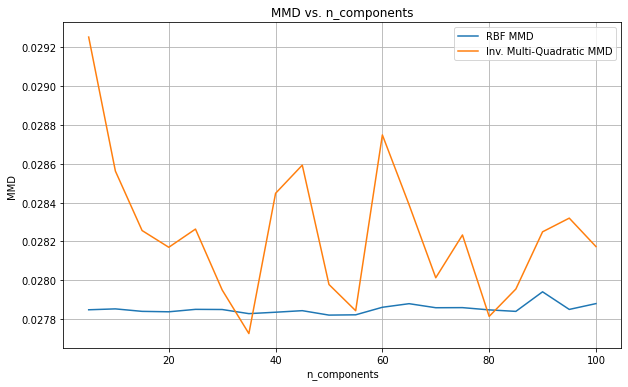

In [ ]:
n_components = list(range(5, 101, 5))
rbf_mmd = []
inv_mmd = []
for _, n in enumerate(n_components):
    n_gmm = GaussianMixture(n_components=n)
    n_gmm.fit(X_train)
    new_samples, _ = n_gmm.sample(len(X_test))
    rbf_mmd.append(MMD(X_test,new_samples, "rbf"))
    inv_mmd.append(MMD(X_test,new_samples, "inverse-multi-quadratic"))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_components, rbf_mmd, label="RBF MMD")
plt.plot(n_components, inv_mmd, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. n_components")
plt.xlabel("n_components")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

plt.show()

Furthe we test the influence of the dataset size with the optimal n_component size

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


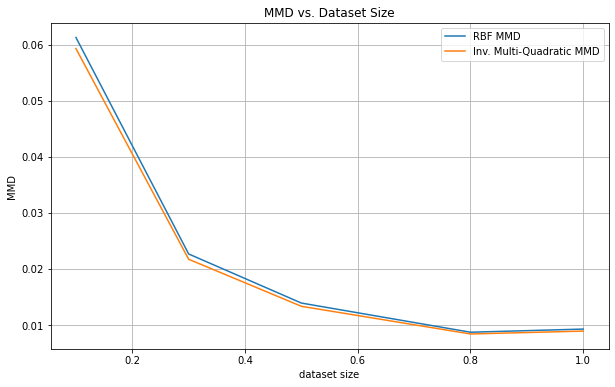

In [ ]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_gmm = []
inv_gmm = []
var_data_gmm = GaussianMixture(n_components=55)

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)

    # Train the classifier on the current dataset size
    var_data_gmm.fit(X)
    new_samples, _ = var_data_gmm.sample(len(X))
    rbf_gmm.append(MMD(X,new_samples, "rbf"))
    inv_gmm.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_gmm, label="RBF MMD")
plt.plot(dataset_sizes, inv_gmm, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

Also here the model improves with dataset size

## Kernel Density Estimator (KDE)

Now we implement a kernel density estimator (KDE) with squared exponential kernel

MMD with squared exponential kernel: 0.0279159077840152
MMD with inverse multi quadratic kernel: 0.02835229671311289


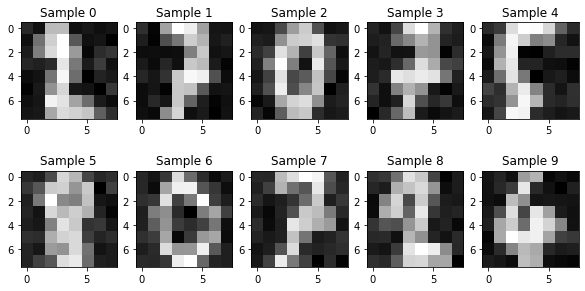

In [ ]:
from sklearn.neighbors import KernelDensity
bandwidth = 1.1
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(X_train)
new_samples = kde.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

new_samples = kde.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

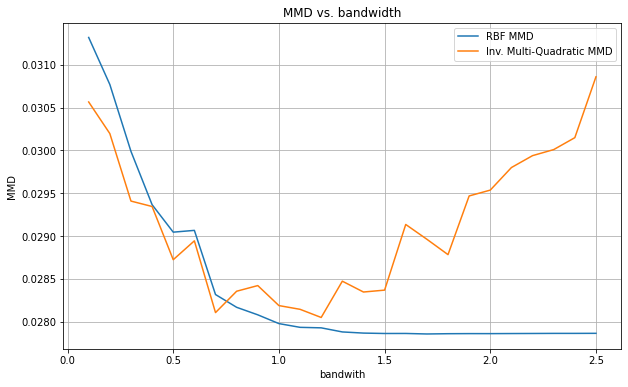

In [ ]:
bandwidths = np.arange(0.1, 2.6, 0.1)
rbf_mmd = []
inv_mmd = []
for _, bandwidth in enumerate(bandwidths):
    n_kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    n_kde.fit(X_train)
    new_samples = n_kde.sample(len(X_test))
    rbf_mmd.append(MMD(X_test,new_samples, "rbf"))
    inv_mmd.append(MMD(X_test,new_samples, "inverse-multi-quadratic"))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, rbf_mmd, label="RBF MMD")
plt.plot(bandwidths, inv_mmd, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. bandwidth")
plt.xlabel("bandwith")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

plt.show()

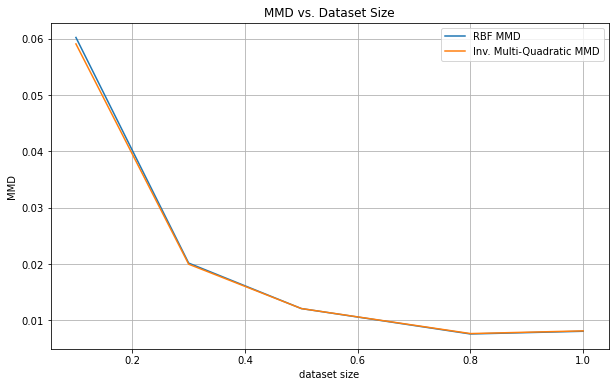

In [ ]:
# Create a list of dataset sizes you want to use
dataset_sizes = [0.1, 0.3, 0.5, 0.8, 1.0]  # Fraction of the original dataset size
rbf_kde = []
inv_kde = []
var_data_gaussian = KernelDensity(bandwidth=1.1, kernel='gaussian')

for size in dataset_sizes:
    # Split the dataset into a training sets with the desired size
    if size == 1.0:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=None)
    else:
        X, _, y, _ = train_test_split(X_train, y_train, test_size=1 - size)

    # Train the classifier on the current dataset size
    var_data_gaussian.fit(X)
    new_samples = var_data_gaussian.sample(len(X))
    rbf_kde.append(MMD(X,new_samples, "rbf"))
    inv_kde.append(MMD(X,new_samples, "inverse-multi-quadratic"))
    # Create the plot


plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, rbf_kde, label="RBF MMD")
plt.plot(dataset_sizes, inv_kde, label="Inv. Multi-Quadratic MMD")

plt.title("MMD vs. Dataset Size")
plt.xlabel("dataset size")
plt.ylabel("MMD")
plt.legend()
plt.grid(True)

## Random Forest Classifier
Finally we implement a Random forest classifier on the original dataset to destinguish the 10 digits. Further we will use this classifier to check if the models are working reasonably and that the 10 digits are generated in equal proportion

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on the test data: 0.99


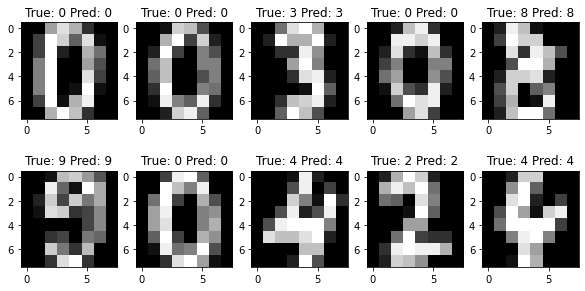

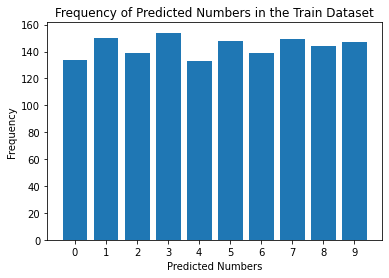

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test data: {accuracy:.2f}")
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"True: {y_test[i]} Pred: {y_pred[i]}")
plt.show()

y_pred = rf_classifier.predict(X_train)
# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers in the Train Dataset")
plt.show()

We can see, the Classifier does a really good job on classifying the test dataset. Also the frequency of each predicted class in the training dataset is very evanly spaced out. So now, lets test the classifier on generated data samples from each model!

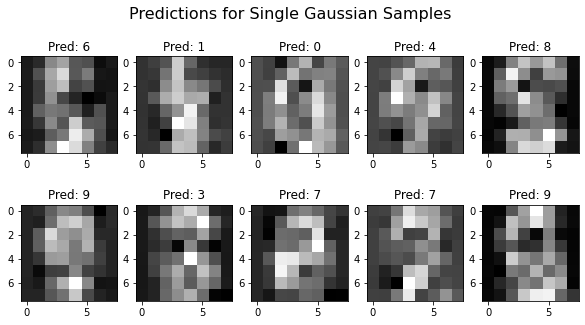

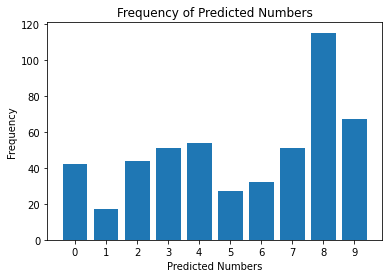

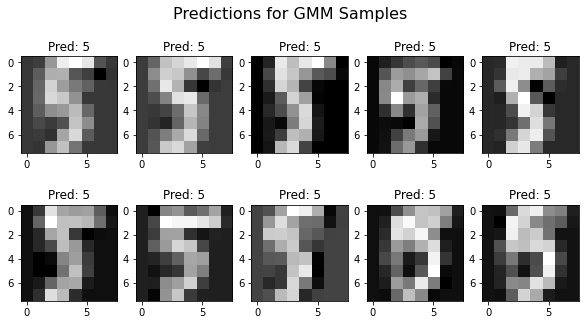

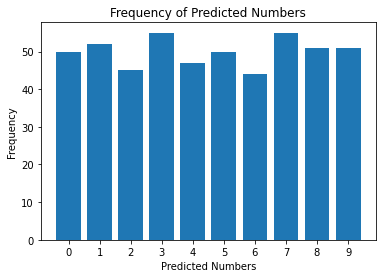

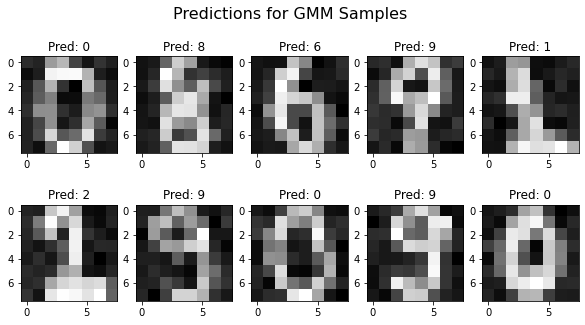

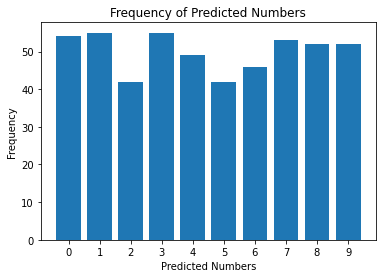

In [ ]:
sample_size = 500
samples_gauss, _ = single_gaussian.sample(sample_size)
samples_gmm, _ = gmm.sample(sample_size)
samples_kde = kde.sample(sample_size)


y_pred_gauss = rf_classifier.predict(samples_gauss)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_gauss[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_gauss[i]}")
fig.suptitle("Predictions for Single Gaussian Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_gauss)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

y_pred_gmm = rf_classifier.predict(samples_gmm)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_gmm[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_gmm[i]}")
fig.suptitle("Predictions for GMM Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_gmm)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

y_pred_kde = rf_classifier.predict(samples_kde)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples_kde[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Pred: {y_pred_kde[i]}")
fig.suptitle("Predictions for GMM Samples", fontsize=16)
plt.show()

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_pred_kde)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

From the plot we can see, that the single Gaussian performs the worst on the training dataset since a disproportinal amount of the generated images get classified as the digit 8. The GMM and the KDE both have substentially better results, where the generated images are more evanly classified throughout the classes, suggesting better generated data samples